# Lib Import

In [109]:
import os 
from datetime import datetime
import pandas as pd
import networkx as nx 
import matplotlib.pyplot as plt
import community as community_louvain
import random
import igraph as ig
import leidenalg
from collections import defaultdict
from networkx.algorithms.community.quality import modularity
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  classification_report
from xgboost import XGBClassifier

import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.utils import from_networkx
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay




# Data Load

## GRN - Gene Regulatory Network
| Column         | Meaning                                                                                                                                           |
| -------------- | ------------------------------------------------------------------------------------------------------------------------------------------------- |
| **TF**         | Transcription factor (gene) that regulates others — this is your **source node** in the GRN.                                                      |
| **Target**     | The gene that is being regulated by the TF — this is your **target node** in the GRN.                                                             |
| **Regulation** | The type of regulation: typically **“Activation”** or **“Repression”**, describing whether the TF increases or decreases the target’s expression. |
| **PMID**       | PubMed ID of the publication providing evidence for this TF–target relationship.                                                                  |


In [110]:
#Load the GRN database
grn_df = pd.read_csv('Data/trrust_rawdata.human.tsv', sep = '\t', header=None,names=["TF", "Target", "Regulation", "PMID"])	
grn_df.head()

,TF,Target,Regulation,PMID
0,AATF,BAX,Repression,22909821
1,AATF,CDKN1A,Unknown,17157788
2,AATF,KLK3,Unknown,23146908
3,AATF,MYC,Activation,20549547
4,AATF,TP53,Unknown,17157788


In [254]:
unique_tf = grn_df["TF"].unique()
unique_target = grn_df["Target"].unique()

unique_genes = set(unique_tf).union(unique_target)

unique_gene_list = sorted(list(unique_genes))

print(unique_gene_list) #unique gene list
print(len(unique_gene_list)) #number of unique genes

['A2M', 'AATF', 'ABCA1', 'ABCA3', 'ABCB1', 'ABCB11', 'ABCB4', 'ABCB8', 'ABCC1', 'ABCC2', 'ABCC3', 'ABCC4', 'ABCC6', 'ABCG1', 'ABCG2', 'ABCG4', 'ABCG5', 'ABCG8', 'ABL1', 'ABL2', 'ACACA', 'ACACB', 'ACADL', 'ACAN', 'ACAT1', 'ACAT2', 'ACBD3', 'ACE', 'ACE2', 'ACHE', 'ACKR1', 'ACKR3', 'ACLY', 'ACO1', 'ACOT7', 'ACOX1', 'ACP5', 'ACR', 'ACRV1', 'ACSL1', 'ACTA1', 'ACTA2', 'ACTC1', 'ACTG2', 'ACTN4', 'ACVRL1', 'ADA', 'ADAM10', 'ADAM12', 'ADAM17', 'ADAM23', 'ADAMTS1', 'ADAMTS5', 'ADARB2', 'ADGRB1', 'ADGRE5', 'ADH1A', 'ADH5', 'ADH6', 'ADIPOQ', 'ADIPOR1', 'ADIPOR2', 'ADM', 'ADORA1', 'ADORA2A', 'ADORA3', 'ADRA1A', 'ADRA2B', 'ADRB2', 'ADRB3', 'AES', 'AFP', 'AGER', 'AGGF1', 'AGO1', 'AGR2', 'AGT', 'AGTR1', 'AHR', 'AHRR', 'AICDA', 'AIP', 'AIRE', 'AK4', 'AKAP12', 'AKR1B1', 'AKR1C2', 'AKR1C3', 'AKR1C4', 'AKT1', 'AKT2', 'ALAS1', 'ALAS2', 'ALB', 'ALDH1A1', 'ALDH1A2', 'ALDH1A3', 'ALDOA', 'ALDOB', 'ALK', 'ALKBH2', 'ALOX12', 'ALOX15', 'ALOX15B', 'ALOX5', 'ALOX5AP', 'ALPI', 'ALPL', 'AMACR', 'AMH', 'AMHR2', 'ANAPC

In [112]:
#Create a graph from the dataframe
G = nx.from_pandas_edgelist(grn_df, source="TF", target="Target", create_using=nx.DiGraph())

In [ ]:
# Load the disease knowledge database
# This file contains gene-disease associations
disease_df = pd.read_csv("Data/human_disease_knowledge_full.tsv", sep='\t', header=None,
                         names=["GeneID", "GeneName", "DiseaseID", "DiseaseName",
                                "SourceDB", "EvidenceType", "Confidence"])

disease_genes = set(disease_df["GeneName"].dropna().unique())
print(f"Loaded {len(disease_genes)} unique disease genes")

Loaded 3839 unique disease genes


In [ ]:
# Create a label dictionary for the nodes in the graph
# 1 for disease genes, 0 for non-disease genes
labels = {}
for node in G.nodes():
    labels[node] = int(node in disease_genes)


In [ ]:
# Extract features for each node in the graph
# Using degree centrality and PageRank as features
features = {}
degree_dict = dict(G.degree())
pagerank_dict = nx.pagerank(G)

for node in G.nodes():
    features[node] = [
        degree_dict.get(node, 0),
        pagerank_dict.get(node, 0.0),
    ]


In [116]:
#Graph info
print(G)
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

degrees = dict(G.degree)
degree_values = list(degrees.values())
average_degree = sum(degree_values) / G.number_of_nodes()
print('Average degree:', average_degree)

density = nx.density(G)
print('Density:', density)

is_connected = nx.is_connected(G) if nx.is_connected(G.to_undirected()) else False
print('Is connected:', is_connected)

if is_connected:
    diameter = nx.diameter(G)
    print('Diameter:', diameter)

    average_shortest_path_length = nx.average_shortest_path_length(G)
    print('Average shortest path length:', average_shortest_path_length)
else:
    print('Graph is not connected — diameter and average shortest path length undefined.')

clustering_coeff = nx.average_clustering(G)
print('Average clustering coefficient:', clustering_coeff)

try:
    assortativity = nx.degree_assortativity_coefficient(G)
    print('Degree assortativity coefficient:', assortativity)
except Exception as e:
    print('Assortativity could not be computed:', e)

num_components = nx.number_connected_components(G.to_undirected())
print('Number of connected components:', num_components)

largest_cc = max(nx.connected_components(G.to_undirected()), key=len)
print('Size of largest connected component:', len(largest_cc))

degree_histogram = nx.degree_histogram(G)
print('Degree histogram:', degree_histogram)

DiGraph with 2862 nodes and 8427 edges
Number of nodes: 2862
Number of edges: 8427
Average degree: 5.888888888888889
Density: 0.0010291661812109208
Is connected: False
Graph is not connected — diameter and average shortest path length undefined.
Average clustering coefficient: 0.06684582437052157
Degree assortativity coefficient: -0.1071399973508695
Number of connected components: 26
Size of largest connected component: 2804
Degree histogram: [0, 1077, 549, 305, 207, 139, 79, 72, 46, 40, 36, 29, 31, 19, 12, 16, 15, 13, 9, 5, 8, 11, 8, 6, 6, 10, 9, 5, 4, 5, 9, 4, 5, 4, 2, 5, 3, 3, 2, 0, 2, 1, 2, 1, 1, 0, 1, 3, 3, 0, 2, 1, 1, 0, 0, 0, 0, 0, 3, 3, 0, 0, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,

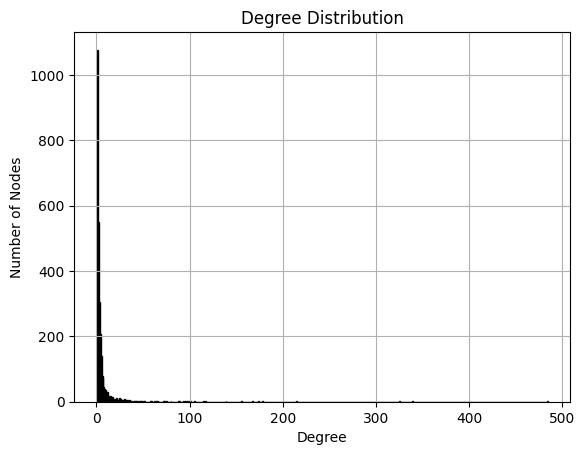

In [117]:
degrees = [d for n, d in G.degree()]
plt.figure()
plt.hist(degrees, bins=range(min(degrees), max(degrees)+2), align='left', edgecolor='black')
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.grid(True)
plt.show()

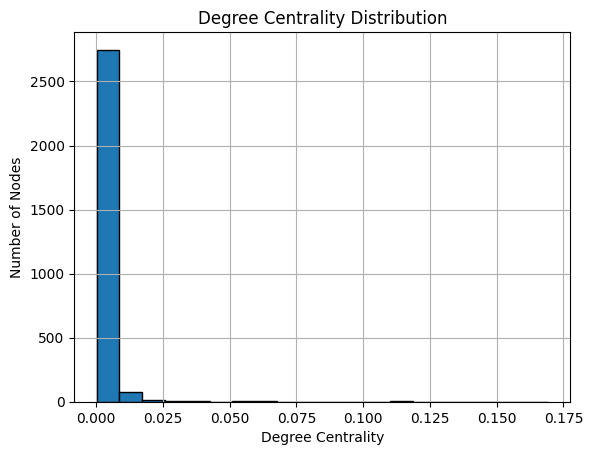

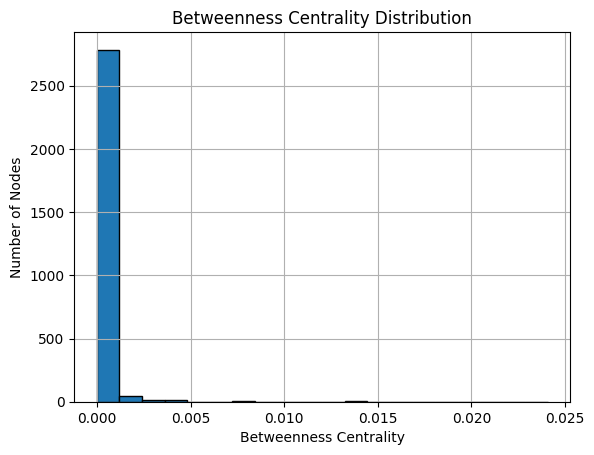

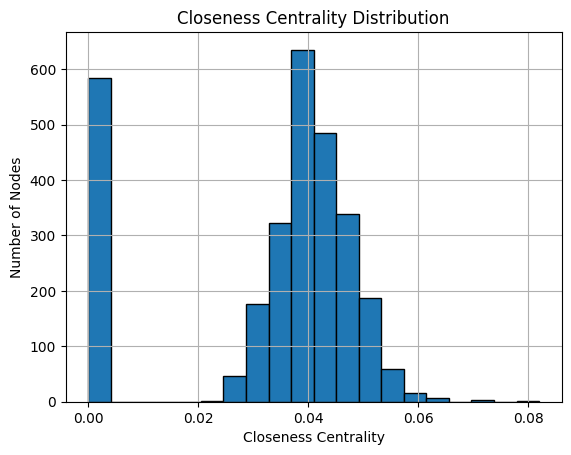

In [118]:
# Degree centrality
degree_centrality = nx.degree_centrality(G)
plt.figure()
plt.hist(list(degree_centrality.values()), bins=20, edgecolor='black')
plt.title('Degree Centrality Distribution')
plt.xlabel('Degree Centrality')
plt.ylabel('Number of Nodes')
plt.grid(True)
plt.show()

# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
plt.figure()
plt.hist(list(betweenness_centrality.values()), bins=20, edgecolor='black')
plt.title('Betweenness Centrality Distribution')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Number of Nodes')
plt.grid(True)
plt.show()

# Closeness centrality
closeness_centrality = nx.closeness_centrality(G)
plt.figure()
plt.hist(list(closeness_centrality.values()), bins=20, edgecolor='black')
plt.title('Closeness Centrality Distribution')
plt.xlabel('Closeness Centrality')
plt.ylabel('Number of Nodes')
plt.grid(True)
plt.show()


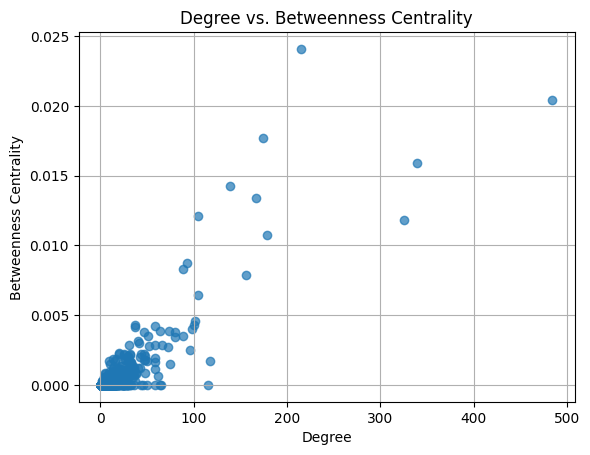

In [119]:
import matplotlib.pyplot as plt

degrees = dict(G.degree())
betweenness = nx.betweenness_centrality(G)

x = [degrees[n] for n in G.nodes()]
y = [betweenness[n] for n in G.nodes()]

plt.figure()
plt.scatter(x, y, alpha=0.7)
plt.title('Degree vs. Betweenness Centrality')
plt.xlabel('Degree')
plt.ylabel('Betweenness Centrality')
plt.grid(True)
plt.show()


Number of connected components: 26
Sizes of connected components: [2804, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 4, 3, 1, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2]


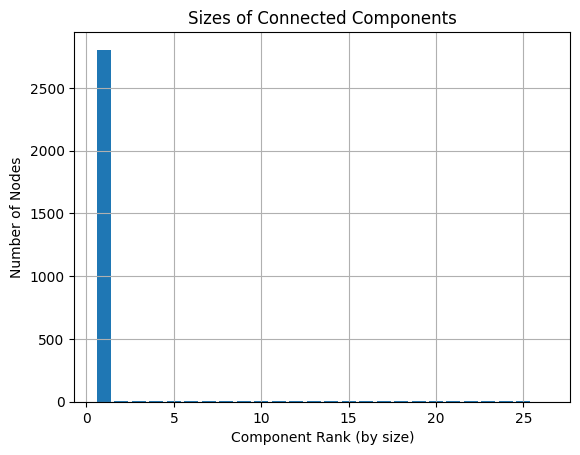

In [ ]:
components = list(nx.connected_components(G.to_undirected()))
component_sizes = [len(c) for c in components]

print('Number of connected components:', len(component_sizes))
print('Sizes of connected components:', component_sizes)

import matplotlib.pyplot as plt

component_sizes.sort(reverse=True)
plt.figure()
plt.bar(range(1, len(component_sizes)+1), component_sizes)
plt.title('Sizes of Connected Components')
plt.xlabel('Component Rank (by size)')
plt.ylabel('Number of Nodes')
plt.grid(True)
plt.show()


---------------

## Communities via Leiden

In [ ]:
# Convert to undirected graph for Leiden algorithm
# Leiden works on undirected graphs, so we convert the directed graph to undirected

G_undir = G.to_undirected()  
G_undir_nx = nx.Graph(G_undir)  

# Convert to igraph
G_ig = ig.Graph.TupleList(G_undir_nx.edges(), directed=False)

# Compute partition with Leiden; use Modularity as objective
partition = leidenalg.find_partition(G_ig, leidenalg.ModularityVertexPartition)

# Number of communities
print(f"Detected {len(partition)} communities.")

# Get node names from igraph graph
node_names = G_ig.vs["name"]

# Create mapping: node -> community ID
node_to_community = {node: comm for node, comm in zip(node_names, partition.membership)}

# Print first few assignments
for n, c in list(node_to_community.items())[:10]:
    print(f"{n}: Community {c}")

# Add community as a node attribute in your original networkx graph
nx.set_node_attributes(G, node_to_community, 'community')

community_df = pd.DataFrame(list(node_to_community.items()), columns=["Gene", "Community"])
community_df.to_csv("output/community_assignments_leiden.csv", index=False)
print("Community assignments saved to community_assignments_leiden.csv")

Detected 43 communities.
AATF: Community 1
BAX: Community 1
CDKN1A: Community 1
KLK3: Community 6
MYC: Community 1
TP53: Community 1
ABL1: Community 11
NFKB1: Community 2
RELA: Community 2
PML: Community 1
Community assignments saved to community_assignments_leiden.csv


In [ ]:
# Communities as list of sets of nodes
leiden_communities_list = [set(group["Gene"]) for _, group in community_df.groupby("Community")]

mod_leiden = modularity(G, leiden_communities_list)

print(f"Leiden modularity: {mod_leiden:.4f}")

Leiden modularity: 0.4593


### Bio significance of communities

#### biological role

In [ ]:
#GO terms are often used to describe the roles of genes in biological processes.
#We will create a binary matrix where each row represents a gene and each column represents a GO term.

# Load gene roles
gene_roles_df = pd.read_csv("output/gene_roles.csv")

# Split GO terms for each gene into lists
gene_roles_df["GO_Terms_List"] = gene_roles_df["GO_Terms"].fillna("").apply(lambda x: [term.strip() for term in x.split(";") if term.strip()])

# Use MultiLabelBinarizer to encode presence/absence of GO terms
mlb = MultiLabelBinarizer()
go_features = mlb.fit_transform(gene_roles_df["GO_Terms_List"])

# Create dataframe: rows=genes, columns=GO terms
go_feature_df = pd.DataFrame(go_features, columns=mlb.classes_)
go_feature_df.insert(0, "Gene", gene_roles_df["Gene"])


# save encoded matrix for reuse
go_feature_df.to_csv("output/gene_go_binary_matrix.csv", index=False)
print("\nSaved: output/gene_go_binary_matrix.csv")
go_feature_df.head()


Saved: output/gene_go_binary_matrix.csv


,Gene,GO:0000012: P:single strand break repair,GO:0000015: C:phosphopyruvate hydratase complex,GO:0000017: P:alpha-glucoside transport,GO:0000038: P:very long-chain fatty acid metabolic process,GO:0000045: P:autophagosome assembly,GO:0000049: F:tRNA binding,GO:0000050: P:urea cycle,GO:0000053: P:argininosuccinate metabolic process,GO:0000062: F:fatty-acyl-CoA binding,...,GO:2001239: P:regulation of extrinsic apoptotic signaling pathway in absence of ligand,GO:2001240: P:negative regulation of extrinsic apoptotic signaling pathway in absence of ligand,GO:2001241: P:positive regulation of extrinsic apoptotic signaling pathway in absence of ligand,GO:2001243: P:negative regulation of intrinsic apoptotic signaling pathway,GO:2001244: P:positive regulation of intrinsic apoptotic signaling pathway,GO:2001258: P:negative regulation of cation channel activity,GO:2001259: P:positive regulation of cation channel activity,GO:2001288: P:positive regulation of caveolin-mediated endocytosis,GO:2001303: P:lipoxin A4 biosynthetic process,GO:2001306: P:lipoxin B4 biosynthetic process
0,POU4F2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AVP,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,SCT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,MCM10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,LGALS9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [124]:
# Load encoded gene-GO matrix you just created
go_feature_df = pd.read_csv("output/gene_go_binary_matrix.csv")

# Load community assignments (adjust file for Louvain if needed)
community_df = pd.read_csv("output/community_assignments_leiden.csv")
if "Node" in community_df.columns:
    community_df = community_df.rename(columns={"Node": "Gene"})

# Merge community assignments into the binary matrix
merged = go_feature_df.merge(community_df, on="Gene", how="left")

# Drop the 'Gene' column for aggregation
go_cols = go_feature_df.columns.drop("Gene")

# Sum binary GO features within each community
community_go_profiles = merged.groupby("Community")[go_cols].sum()

# Optional: normalize by community size (percentage of genes with each GO term)
community_sizes = merged.groupby("Community")["Gene"].count()
community_go_percent = community_go_profiles.div(community_sizes, axis=0) * 100


# Save results to output
community_go_profiles.to_csv("output/community_go_term_counts.csv")
community_go_percent.to_csv("output/community_go_term_percentages.csv")
print("\nSaved: community_go_term_counts.csv and community_go_term_percentages.csv")


Saved: community_go_term_counts.csv and community_go_term_percentages.csv


In [125]:
community_go_percent.head()

,GO:0000012: P:single strand break repair,GO:0000015: C:phosphopyruvate hydratase complex,GO:0000017: P:alpha-glucoside transport,GO:0000038: P:very long-chain fatty acid metabolic process,GO:0000045: P:autophagosome assembly,GO:0000049: F:tRNA binding,GO:0000050: P:urea cycle,GO:0000053: P:argininosuccinate metabolic process,GO:0000062: F:fatty-acyl-CoA binding,GO:0000070: P:mitotic sister chromatid segregation,...,GO:2001239: P:regulation of extrinsic apoptotic signaling pathway in absence of ligand,GO:2001240: P:negative regulation of extrinsic apoptotic signaling pathway in absence of ligand,GO:2001241: P:positive regulation of extrinsic apoptotic signaling pathway in absence of ligand,GO:2001243: P:negative regulation of intrinsic apoptotic signaling pathway,GO:2001244: P:positive regulation of intrinsic apoptotic signaling pathway,GO:2001258: P:negative regulation of cation channel activity,GO:2001259: P:positive regulation of cation channel activity,GO:2001288: P:positive regulation of caveolin-mediated endocytosis,GO:2001303: P:lipoxin A4 biosynthetic process,GO:2001306: P:lipoxin B4 biosynthetic process
Community,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.58309,0.291545
1,0.0,0.347222,0.0,0.000000,1.041667,0.347222,0.000000,0.0,0.000000,0.000000,...,0.347222,0.347222,0.0,0.0,1.041667,0.0,0.000000,0.0,0.00000,0.000000
2,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.343643,0.0,0.0,0.000000,0.0,0.343643,0.0,0.00000,0.000000
3,0.0,0.000000,0.0,0.434783,0.000000,0.000000,0.434783,0.0,1.304348,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
4,0.0,0.000000,0.0,0.000000,0.526316,0.000000,0.526316,0.0,0.000000,0.526316,...,0.000000,1.052632,0.0,0.0,1.052632,0.0,0.526316,0.0,0.00000,0.000000


In [126]:
# Load your community GO term percentages file
community_go_percent = pd.read_csv("output/community_go_term_percentages.csv")

# For each community, find the top N GO terms by percentage
top_go_terms = {}
N = 20  # top N terms to display per community

for _, row in community_go_percent.iterrows():
    community_id = row["Community"]
    go_percentages = row.drop("Community")
    
    # Sort GO terms by descending percentage
    top_terms = go_percentages.sort_values(ascending=False).head(N)
    
    top_go_terms[community_id] = top_terms

# Print a few examples
for comm, terms in list(top_go_terms.items())[:3]:
    print(f"\nCommunity {comm}:")
    for go_term, perc in terms.items():
        print(f"  {go_term}: {perc:.1f}% of genes")


Community 0.0:
  GO:0005886: C:plasma membrane: 19.8% of genes
  GO:0005634: C:nucleus: 19.0% of genes
  GO:0016020: C:membrane: 16.9% of genes
  GO:0005829: C:cytosol: 16.3% of genes
  GO:0005737: C:cytoplasm: 15.5% of genes
  GO:0005654: C:nucleoplasm: 14.6% of genes
  GO:0005576: C:extracellular region: 12.2% of genes
  GO:0070062: C:extracellular exosome: 9.9% of genes
  GO:0005615: C:extracellular space: 9.0% of genes
  GO:0046872: F:metal ion binding: 8.5% of genes
  GO:0003677: F:DNA binding: 8.2% of genes
  GO:0008270: F:zinc ion binding: 7.6% of genes
  GO:0045944: P:positive regulation of transcription by RNA polymerase II: 7.3% of genes
  GO:0042802: F:identical protein binding: 7.0% of genes
  GO:0006357: P:regulation of transcription by RNA polymerase II: 7.0% of genes
  GO:0000785: C:chromatin: 6.7% of genes
  GO:0000981: F:DNA-binding transcription factor activity, RNA polymerase II-specific: 6.1% of genes
  GO:1990837: F:sequence-specific double-stranded DNA binding: 6

In [127]:
# Define keyword categories for interpretation
categories = {
    "G-protein signaling": ["g-protein", "g protein coupled receptor"],
    "MAPK signaling": ["mapk", "mitogen-activated protein kinase"],
    "cytokine signaling": ["cytokine"],
    "transcription initiation": ["transcription initiation"],
    "chromatin remodeling": ["chromatin"],
    "RNA polymerase II regulation": ["rna polymerase ii", "cis-regulatory"],
    "apoptosis": ["apoptotic"],
    "immune response": ["immune", "inflammatory", "chemotaxis"],
    "membrane transport": ["channel", "transport"],
    "metal ion binding": ["metal ion binding", "zinc ion binding", "calcium ion binding"],
}

community_summaries = {}

for comm, terms in top_go_terms.items():
    summary_counts = {key: 0 for key in categories}
    
    for go_term_desc in terms.index:  # using GO term descriptions as column names
        desc_lower = go_term_desc.lower()
        for category, keywords in categories.items():
            if any(kw in desc_lower for kw in keywords):
                summary_counts[category] += 1

    # Determine dominant categories with at least one match
    sorted_summary = sorted(summary_counts.items(), key=lambda x: x[1], reverse=True)
    dominant = [cat for cat, count in sorted_summary if count > 0]
    
    if dominant:
        summary_text = f"{', '.join(dominant)} processes."
    else:
        summary_text = "No clear dominant biological role found."
    
    community_summaries[comm] = summary_text

# Print a few example summaries
for comm, summary in list(community_summaries.items())[:5]:
    print(f"\nCommunity {comm}: {summary}")

# Optionally save summaries
import pandas as pd
summary_df = pd.DataFrame(list(community_summaries.items()), columns=["Community", "Summary"])
summary_df.to_csv("output/community_role_summaries.csv", index=False)
print("\nSaved: output/community_role_summaries.csv")



Community 0.0: RNA polymerase II regulation, metal ion binding, chromatin remodeling processes.

Community 1.0: RNA polymerase II regulation, chromatin remodeling, apoptosis, metal ion binding processes.

Community 2.0: RNA polymerase II regulation, immune response, cytokine signaling, metal ion binding processes.

Community 3.0: RNA polymerase II regulation, chromatin remodeling, metal ion binding processes.

Community 4.0: RNA polymerase II regulation, immune response, metal ion binding processes.

Saved: output/community_role_summaries.csv


In [128]:
summary_df

,Community,Summary
0,0.0,"RNA polymerase II regulation, metal ion bindin..."
1,1.0,"RNA polymerase II regulation, chromatin remode..."
2,2.0,"RNA polymerase II regulation, immune response,..."
3,3.0,"RNA polymerase II regulation, chromatin remode..."
4,4.0,"RNA polymerase II regulation, immune response,..."
5,5.0,"RNA polymerase II regulation, chromatin remode..."
6,6.0,"RNA polymerase II regulation, chromatin remode..."
7,7.0,"RNA polymerase II regulation, metal ion bindin..."
8,8.0,"RNA polymerase II regulation, chromatin remode..."
9,9.0,"RNA polymerase II regulation, metal ion bindin..."


## Enrichment analysis

#### Diseases 

In [ ]:
# Load the disease knowledge database

disease_df = pd.read_csv("Data/human_disease_knowledge_full.tsv", sep="\t", header=None,
                         names=["GeneID", "GeneName", "DiseaseID", "DiseaseName", "SourceDB", "EvidenceType", "Confidence"])

# Prepare disease genes set
disease_genes = set(disease_df["GeneName"].dropna().unique())

def enrichment_analysis(df, method_name):
    results = []
    total_disease = sum(df["Gene"].isin(disease_genes))
    total_non_disease = len(df) - total_disease

    for comm_id, group in df.groupby("Community"):
        genes_in_comm = set(group["Gene"])
        disease_in_comm = len(genes_in_comm & disease_genes)
        non_disease_in_comm = len(genes_in_comm) - disease_in_comm

        disease_outside = total_disease - disease_in_comm
        non_disease_outside = total_non_disease - non_disease_in_comm

        table = [[disease_in_comm, non_disease_in_comm],
                 [disease_outside, non_disease_outside]]

        _, p_value = fisher_exact(table, alternative="greater")
        results.append({"Community": comm_id, "PValue": p_value, "DiseaseGenes": disease_in_comm, "TotalGenes": len(genes_in_comm)})

    res_df = pd.DataFrame(results)
    res_df["FDR"] = multipletests(res_df["PValue"], method="fdr_bh")[1] #FDR is False Discovery Rate 
                                                                        #the method used to correct for multiple comparisons 
                                                                        #It’s the expected proportion of false positives 
                                                                        #(incorrectly rejected null hypotheses) among all 
                                                                        #positive findings (rejected null hypotheses).
    res_df["Method"] = method_name
    return res_df.sort_values("FDR")

lei_res = enrichment_analysis(community_df, "Leiden")

print("\nTop enriched Leiden communities:")
print(lei_res.head())

# save
lei_res.to_csv("output/enrichment_leiden.csv", index=False)




Top enriched Leiden communities:
    Community    PValue  DiseaseGenes  TotalGenes       FDR  Method
7           7  0.000286            85         169  0.011287  Leiden
16         16  0.000525            20          29  0.011287  Leiden
14         14  0.019741            41          84  0.282959  Leiden
2           2  0.824310           102         291  1.000000  Leiden
3           3  0.469065            87         230  1.000000  Leiden


In [130]:
lei_res

,Community,PValue,DiseaseGenes,TotalGenes,FDR,Method
7,7,0.000286,85,169,0.011287,Leiden
16,16,0.000525,20,29,0.011287,Leiden
14,14,0.019741,41,84,0.282959,Leiden
2,2,0.824310,102,291,1.000000,Leiden
3,3,0.469065,87,230,1.000000,Leiden
4,4,0.792097,67,192,1.000000,Leiden
5,5,0.648487,65,179,1.000000,Leiden
0,0,0.597543,127,344,1.000000,Leiden
6,6,0.781877,60,172,1.000000,Leiden
8,8,0.626334,58,159,1.000000,Leiden


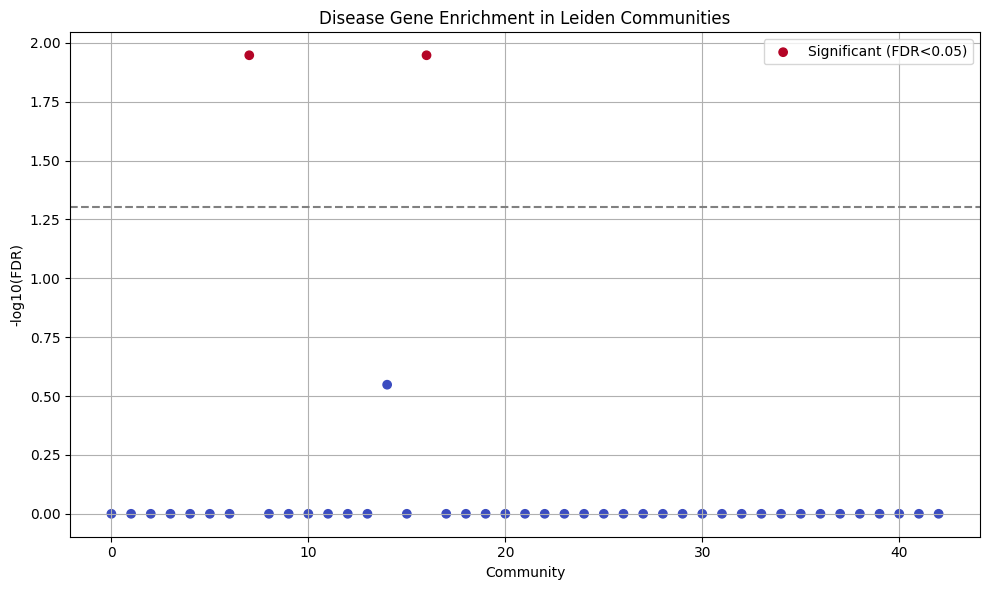

In [ ]:
# Function to plot enrichment results
def plot_enrichment(res_df, method_name):
    sig = res_df[res_df["FDR"] < 0.05]
    plt.figure(figsize=(10,6))
    plt.scatter(res_df["Community"], -np.log10(res_df["FDR"]), 
                c=res_df["FDR"] < 0.05, cmap="coolwarm", label="Significant (FDR<0.05)")
    plt.axhline(-np.log10(0.05), color='gray', linestyle='--')
    plt.title(f"Disease Gene Enrichment in {method_name} Communities")
    plt.xlabel("Community")
    plt.ylabel("-log10(FDR)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_enrichment(lei_res, "Leiden")

 Key findings from Leiden
* Number of communities tested: 44

* Lowest FDR achieved: 0.2432 (Community 6)
 
* Communities with FDR < 0.05: 0 communities
 
* A few communities have promising raw p-values (e.g., p=0.0055), but again, nothing survives multiple testing correction.



------------

### Gene roles 

In [132]:

# Load TRRUST
trrust_df = pd.read_csv("Data/trrust_rawdata.human.tsv", sep="\t", header=None,
                        names=["TF", "Target", "Regulation", "PMID"])

# Assign roles to TFs based on outgoing edges
tf_roles = {}

for tf, group in trrust_df.groupby("TF"):
    regs = group["Regulation"].str.lower().unique()
    activ = any("activation" in r for r in regs)
    reprs = any("repression" in r for r in regs)
    
    if activ and reprs:
        tf_roles[tf] = "Dual"
    elif activ:
        tf_roles[tf] = "Activator"
    elif reprs:
        tf_roles[tf] = "Repressor"
    else:
        tf_roles[tf] = "Unknown"

# Build dataframe of TF roles
tf_roles_df = pd.DataFrame(list(tf_roles.items()), columns=["Gene", "TFRole"])

# Load your community assignments
community_df = pd.read_csv("output/community_assignments_leiden.csv")  # or Louvain
if "Node" in community_df.columns:
    community_df = community_df.rename(columns={"Node": "Gene"})

# Merge TF roles with community assignments
merged = community_df.merge(tf_roles_df, on="Gene", how="left").fillna("Unknown")

# Count number of each role per community
role_summary = (
    merged.groupby(["Community", "TFRole"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

print("\n=== Community regulatory role summary ===")
print(role_summary.head())

# Save summary table
role_summary.to_csv("output/community_tf_roles_summary.csv", index=False)
tf_roles_df.to_csv("output/gene_regulatory_roles.csv", index=False)


=== Community regulatory role summary ===
TFRole  Community  Activator  Dual  Repressor  Unknown
0               0         13    22         15      294
1               1         15    35         23      219
2               2         11    29          9      242
3               3         19    27         11      173
4               4          5    17          7      163


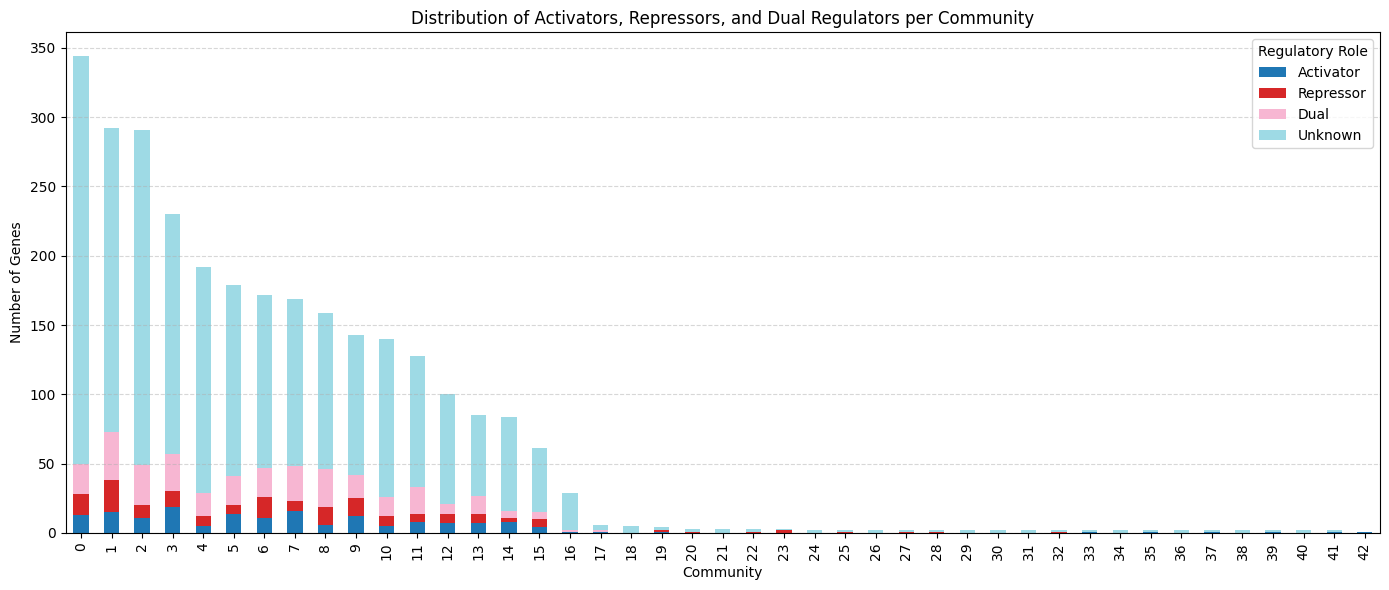

In [133]:
role_summary = pd.read_csv("output/community_tf_roles_summary.csv")

role_summary = role_summary.set_index("Community")  # index by community for easy plotting
# Create stacked bar plot
role_columns = ["Activator", "Repressor", "Dual", "Unknown"]

role_summary[role_columns].plot(kind="bar", stacked=True, figsize=(14,6), colormap="tab20")

plt.title("Distribution of Activators, Repressors, and Dual Regulators per Community")
plt.xlabel("Community")
plt.ylabel("Number of Genes")
plt.legend(title="Regulatory Role")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

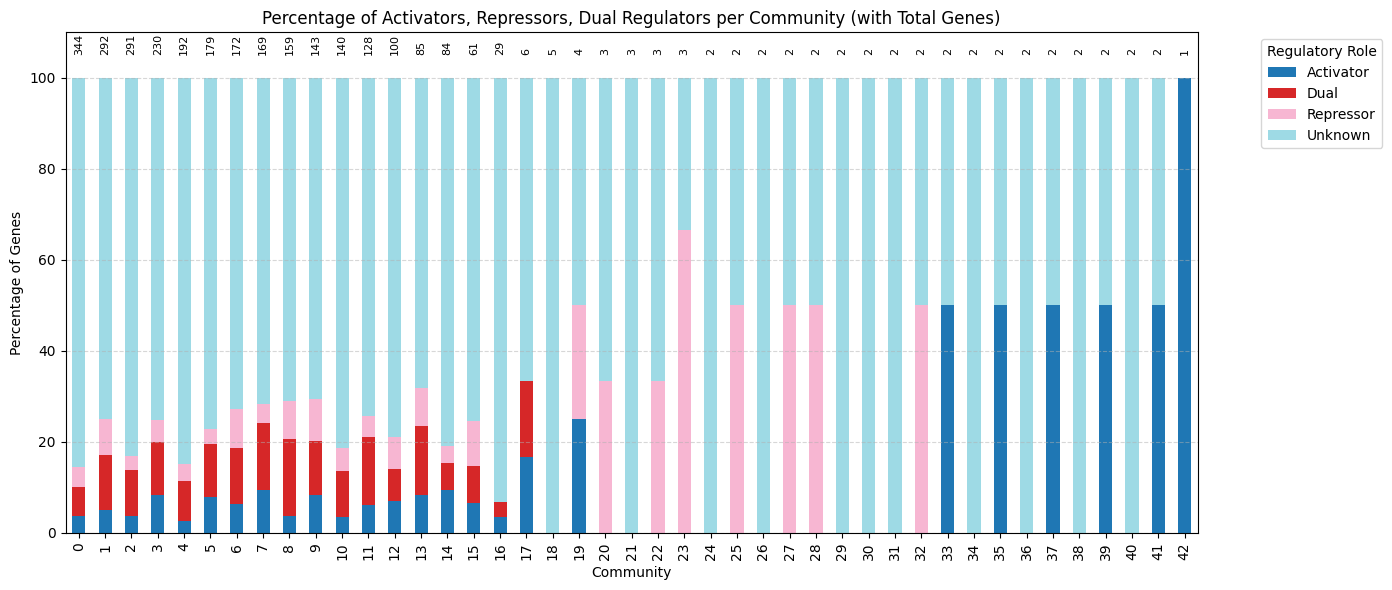

In [134]:

# Reload your summary to be sure
role_summary = pd.read_csv("output/community_tf_roles_summary.csv")

# Identify role columns automatically (skip the Community column)
role_cols = [col for col in role_summary.columns if col != "Community"]

# Calculate total genes per community
role_summary["TotalGenes"] = role_summary[role_cols].sum(axis=1)

# Calculate percentages
role_percentages = role_summary.copy()
for col in role_cols:
    role_percentages[col] = (role_summary[col] / role_summary["TotalGenes"]) * 100

role_percentages = role_percentages.set_index("Community")

# Create stacked bar plot with percentages
ax = role_percentages[role_cols].plot(kind="bar", stacked=True, figsize=(14,6), colormap="tab20")

# Add annotations for total genes above each bar
for idx, total in enumerate(role_summary["TotalGenes"]):
    ax.text(idx, 105, f"{total}", ha="center", va="bottom", fontsize=8, rotation=90)

plt.title("Percentage of Activators, Repressors, Dual Regulators per Community (with Total Genes)")
plt.xlabel("Community")
plt.ylabel("Percentage of Genes")
plt.ylim(0, 110)  # 100% + room for annotations
plt.legend(title="Regulatory Role", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()



=== Top 10 communities by size ===
   Community  Activator  Dual  Repressor  Unknown  TotalGenes
0          0         13    22         15      294         344
1          1         15    35         23      219         292
2          2         11    29          9      242         291
3          3         19    27         11      173         230
4          4          5    17          7      163         192
5          5         14    21          6      138         179
6          6         11    21         15      125         172
7          7         16    25          7      121         169
8          8          6    27         13      113         159
9          9         12    17         13      101         143


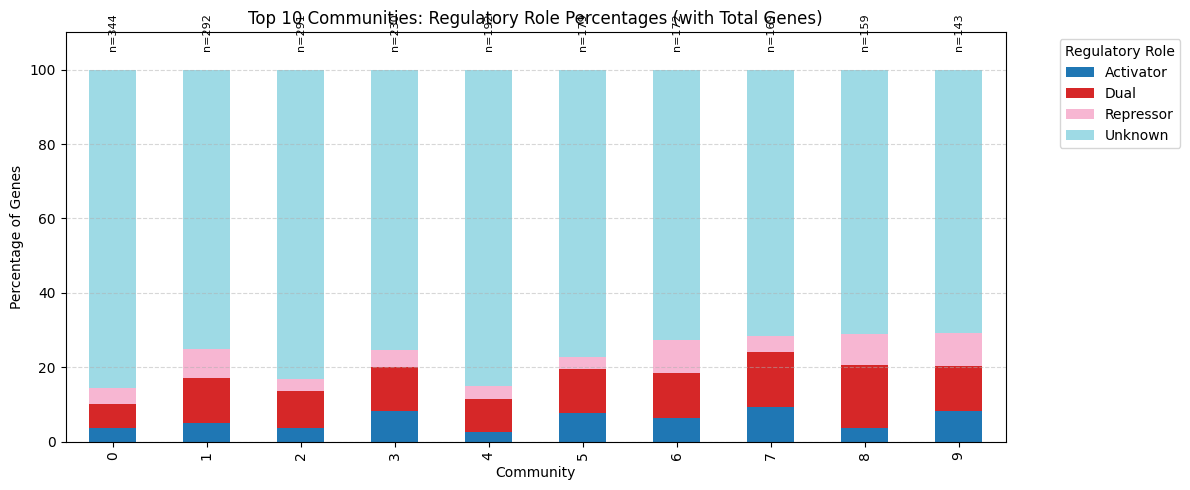

In [135]:
# Sort your role summary by total genes
top_communities = role_summary.sort_values("TotalGenes", ascending=False).head(10)
print("\n=== Top 10 communities by size ===")
print(top_communities)

# Optionally re-plot only these top communities
top_percentages = role_percentages.loc[top_communities["Community"]]

import matplotlib.pyplot as plt

ax = top_percentages[role_cols].plot(kind="bar", stacked=True, figsize=(12,5), colormap="tab20")
for idx, total in enumerate(top_communities["TotalGenes"]):
    ax.text(idx, 105, f"n={total}", ha="center", va="bottom", fontsize=8, rotation=90)

plt.title("Top 10 Communities: Regulatory Role Percentages (with Total Genes)")
plt.xlabel("Community")
plt.ylabel("Percentage of Genes")
plt.ylim(0, 110)
plt.legend(title="Regulatory Role", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

In [136]:
print(role_summary.columns)
print(role_summary.head())

Index(['Community', 'Activator', 'Dual', 'Repressor', 'Unknown', 'TotalGenes'], dtype='object')
   Community  Activator  Dual  Repressor  Unknown  TotalGenes
0          0         13    22         15      294         344
1          1         15    35         23      219         292
2          2         11    29          9      242         291
3          3         19    27         11      173         230
4          4          5    17          7      163         192


In [137]:
enrichment_df = pd.read_csv("output/enrichment_leiden.csv")
print(enrichment_df.columns)
print(enrichment_df.head())


Index(['Community', 'PValue', 'DiseaseGenes', 'TotalGenes', 'FDR', 'Method'], dtype='object')
   Community    PValue  DiseaseGenes  TotalGenes       FDR  Method
0          7  0.000286            85         169  0.011287  Leiden
1         16  0.000525            20          29  0.011287  Leiden
2         14  0.019741            41          84  0.282959  Leiden
3          2  0.824310           102         291  1.000000  Leiden
4          3  0.469065            87         230  1.000000  Leiden


In [138]:
merged_summary = top_communities.merge(
    enrichment_df.rename(columns={"community": "Community"}), 
    on="Community", how="left"
)

In [139]:
# Reload your community role summary (counts table with TotalGenes)
role_summary = pd.read_csv("output/community_tf_roles_summary.csv")

# Identify role columns (everything except Community)
role_cols = [col for col in role_summary.columns if col != "Community"]

# Calculate TotalGenes if not already present
if "TotalGenes" not in role_summary.columns:
    role_summary["TotalGenes"] = role_summary[role_cols].sum(axis=1)

print("\nColumns in role summary:", role_summary.columns)
print(role_summary.head())


Columns in role summary: Index(['Community', 'Activator', 'Dual', 'Repressor', 'Unknown', 'TotalGenes'], dtype='object')
   Community  Activator  Dual  Repressor  Unknown  TotalGenes
0          0         13    22         15      294         344
1          1         15    35         23      219         292
2          2         11    29          9      242         291
3          3         19    27         11      173         230
4          4          5    17          7      163         192


In [140]:
enrichment_df = pd.read_csv("output/enrichment_leiden.csv")
print("\nColumns in enrichment dataframe:", enrichment_df.columns)
print(enrichment_df.head())


Columns in enrichment dataframe: Index(['Community', 'PValue', 'DiseaseGenes', 'TotalGenes', 'FDR', 'Method'], dtype='object')
   Community    PValue  DiseaseGenes  TotalGenes       FDR  Method
0          7  0.000286            85         169  0.011287  Leiden
1         16  0.000525            20          29  0.011287  Leiden
2         14  0.019741            41          84  0.282959  Leiden
3          2  0.824310           102         291  1.000000  Leiden
4          3  0.469065            87         230  1.000000  Leiden


In [141]:
# Make sure both dataframes use the same key column name
if "Community" not in enrichment_df.columns:
    raise KeyError("Enrichment file is missing a 'Community' column; please check enrichment_leiden.csv.")

# Merge on Community
merged_summary = role_summary.merge(enrichment_df, on="Community", how="left")

print("\nMerged summary columns:", merged_summary.columns)
print(merged_summary.head())


Merged summary columns: Index(['Community', 'Activator', 'Dual', 'Repressor', 'Unknown',
       'TotalGenes_x', 'PValue', 'DiseaseGenes', 'TotalGenes_y', 'FDR',
       'Method'],
      dtype='object')
   Community  Activator  Dual  Repressor  Unknown  TotalGenes_x    PValue  \
0          0         13    22         15      294           344  0.597543   
1          1         15    35         23      219           292  0.947888   
2          2         11    29          9      242           291  0.824310   
3          3         19    27         11      173           230  0.469065   
4          4          5    17          7      163           192  0.792097   

   DiseaseGenes  TotalGenes_y  FDR  Method  
0           127           344  1.0  Leiden  
1            97           292  1.0  Leiden  
2           102           291  1.0  Leiden  
3            87           230  1.0  Leiden  
4            67           192  1.0  Leiden  


In [142]:
diff = (merged_summary["TotalGenes_x"] - merged_summary["TotalGenes_y"]).abs()

if (diff == 0).all():
    print("✅ TotalGenes_x and TotalGenes_y match perfectly! Cleaning up columns...")
    
    # Drop redundant TotalGenes_y
    merged_summary = merged_summary.drop(columns=["TotalGenes_y"])
    
    # Rename TotalGenes_x → TotalGenes
    merged_summary = merged_summary.rename(columns={"TotalGenes_x": "TotalGenes"})
    
    print("Columns after cleanup:", merged_summary.columns)
else:
    print("❗ TotalGenes_x and TotalGenes_y DO NOT match!")
    mismatches = merged_summary[diff != 0]
    print("\nMismatched rows (first few):")
    print(mismatches[["Community", "TotalGenes_x", "TotalGenes_y"]].head())


✅ TotalGenes_x and TotalGenes_y match perfectly! Cleaning up columns...
Columns after cleanup: Index(['Community', 'Activator', 'Dual', 'Repressor', 'Unknown', 'TotalGenes',
       'PValue', 'DiseaseGenes', 'FDR', 'Method'],
      dtype='object')


In [143]:
relevant_cols = ["Community", "TotalGenes"] + [col for col in merged_summary.columns if col in ["Activator", "Repressor", "Dual", "Unknown", "FDR"]]
print("\n=== Top communities: roles + enrichment ===")
print(merged_summary[relevant_cols].sort_values("TotalGenes", ascending=False).head(10))



=== Top communities: roles + enrichment ===
   Community  TotalGenes  Activator  Dual  Repressor  Unknown       FDR
0          0         344         13    22         15      294  1.000000
1          1         292         15    35         23      219  1.000000
2          2         291         11    29          9      242  1.000000
3          3         230         19    27         11      173  1.000000
4          4         192          5    17          7      163  1.000000
5          5         179         14    21          6      138  1.000000
6          6         172         11    21         15      125  1.000000
7          7         169         16    25          7      121  0.011287
8          8         159          6    27         13      113  1.000000
9          9         143         12    17         13      101  1.000000


In [144]:
summaries = []

for _, row in merged_summary.iterrows():
    activ_pct = row["Activator"] / row["TotalGenes"] * 100
    repr_pct = row["Repressor"] / row["TotalGenes"] * 100
    dual_pct = row["Dual"] / row["TotalGenes"] * 100
    summary = (f"Community {int(row['Community'])}: "
               f"{activ_pct:.1f}% activators, {repr_pct:.1f}% repressors, "
               f"{dual_pct:.1f}% dual; FDR={row['FDR']:.3f}. "
               f"{'Pro-activation' if activ_pct > repr_pct else 'Pro-repression' if repr_pct > activ_pct else 'Mixed'} module.")
    summaries.append(summary)

for text in summaries:
    print("\n" + text)

# Optionally save to file
import pandas as pd
pd.DataFrame({"Summary": summaries}).to_csv("output/community_plain_language_summaries.csv", index=False)
print("\nSaved: output/community_plain_language_summaries.csv")



Community 0: 3.8% activators, 4.4% repressors, 6.4% dual; FDR=1.000. Pro-repression module.

Community 1: 5.1% activators, 7.9% repressors, 12.0% dual; FDR=1.000. Pro-repression module.

Community 2: 3.8% activators, 3.1% repressors, 10.0% dual; FDR=1.000. Pro-activation module.

Community 3: 8.3% activators, 4.8% repressors, 11.7% dual; FDR=1.000. Pro-activation module.

Community 4: 2.6% activators, 3.6% repressors, 8.9% dual; FDR=1.000. Pro-repression module.

Community 5: 7.8% activators, 3.4% repressors, 11.7% dual; FDR=1.000. Pro-activation module.

Community 6: 6.4% activators, 8.7% repressors, 12.2% dual; FDR=1.000. Pro-repression module.

Community 7: 9.5% activators, 4.1% repressors, 14.8% dual; FDR=0.011. Pro-activation module.

Community 8: 3.8% activators, 8.2% repressors, 17.0% dual; FDR=1.000. Pro-repression module.

Community 9: 8.4% activators, 9.1% repressors, 11.9% dual; FDR=1.000. Pro-repression module.

Community 10: 3.6% activators, 5.0% repressors, 10.0% dual; F

In [145]:
# Collect details into structured lists
community_ids, activ_pcts, repr_pcts, dual_pcts, unk_pcts, fdrs, interpretations = [], [], [], [], [], [], []

for _, row in merged_summary.iterrows():
    activ_pct = row["Activator"] / row["TotalGenes"] * 100
    repr_pct = row["Repressor"] / row["TotalGenes"] * 100
    dual_pct = row["Dual"] / row["TotalGenes"] * 100
    unk_pct = row["Unknown"] / row["TotalGenes"] * 100
    interpretation = (
        "Pro-activation" if activ_pct > repr_pct
        else "Pro-repression" if repr_pct > activ_pct
        else "Mixed"
    )
    # Append details
    community_ids.append(int(row["Community"]))
    activ_pcts.append(round(activ_pct, 1))
    repr_pcts.append(round(repr_pct, 1))
    dual_pcts.append(round(dual_pct, 1))
    unk_pcts.append(round(unk_pct, 1))
    fdrs.append(round(row["FDR"], 4))
    interpretations.append(interpretation)

# Build the dataframe
summary_df = pd.DataFrame({
    "Community": community_ids,
    "TotalGenes": merged_summary["TotalGenes"],
    "%Activators": activ_pcts,
    "%Repressors": repr_pcts,
    "%Dual": dual_pcts,
    "%Unknown": unk_pcts,
    "FDR": fdrs,
    "Interpretation": interpretations
})


# Save nicely
summary_df.to_csv("output/community_detailed_summary.csv", index=False)
print("\nSaved: output/community_detailed_summary.csv")
summary_df.head()


Saved: output/community_detailed_summary.csv


,Community,TotalGenes,%Activators,%Repressors,%Dual,%Unknown,FDR,Interpretation
0,0,344,3.8,4.4,6.4,85.5,1.0,Pro-repression
1,1,292,5.1,7.9,12.0,75.0,1.0,Pro-repression
2,2,291,3.8,3.1,10.0,83.2,1.0,Pro-activation
3,3,230,8.3,4.8,11.7,75.2,1.0,Pro-activation
4,4,192,2.6,3.6,8.9,84.9,1.0,Pro-repression


-----------------

Export to gefy

In [146]:
import networkx as nx

# Assuming your GRN with community assignments is in a networkx DiGraph G
# and you have a dataframe community_df with columns: Gene, Community

# First, map community assignments into G
community_dict = dict(zip(community_df["Gene"], community_df["Community"]))
nx.set_node_attributes(G, community_dict, "community")

# Export to .gexf (great for Gephi/Cytoscape)
nx.write_gexf(G, "output/GRN_with_communities.gexf")
print("\nSaved: output/GRN_with_communities.gexf — ready to explore in Gephi!")



Saved: output/GRN_with_communities.gexf — ready to explore in Gephi!


-------------------------------------------------------------------------------------

In [147]:

# Compute centralities
degree_centrality = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)

# Build dataframe
features_df = pd.DataFrame.from_dict(degree_centrality, orient="index", columns=["DegreeCentrality"])
features_df["Betweenness"] = features_df.index.map(betweenness)
features_df["Closeness"] = features_df.index.map(closeness)

# Add community assignment
features_df = features_df.merge(community_df, left_index=True, right_on="Gene", how="left")

# Add regulatory role as categorical feature
features_df = features_df.merge(tf_roles_df, on="Gene", how="left")

# One-hot encode categorical features
features_df = pd.get_dummies(features_df, columns=["Community", "TFRole"], dummy_na=True)

features_df.to_csv("output/node_features.csv", index=False)
print("\nSaved: output/node_features.csv")


Saved: output/node_features.csv


In [148]:
# Load disease genes set
disease_df = pd.read_csv("Data/human_disease_knowledge_full.tsv", sep="\t", header=None,
                         names=["GeneID", "GeneName", "DiseaseID", "DiseaseName", "SourceDB", "EvidenceType", "Confidence"])
disease_genes = set(disease_df["GeneName"].dropna().unique())

# Add label column: 1 if gene in disease list, 0 otherwise
features_df["Label"] = features_df["Gene"].apply(lambda x: 1 if x in disease_genes else 0)


##### RF and LR for a baseline

In [149]:

# Prepare features (excluding identifier columns)
X = features_df.drop(columns=["Gene", "Label"])
y = features_df["Label"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))



Accuracy: 0.5916230366492147
ROC AUC: 0.5357691406555073

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.74      0.70       359
           1       0.44      0.34      0.38       214

    accuracy                           0.59       573
   macro avg       0.55      0.54      0.54       573
weighted avg       0.57      0.59      0.58       573


Confusion Matrix:
 [[267  92]
 [142  72]]


In [150]:
features_df["PredictedProbability"] = clf.predict_proba(X)[:,1]
features_df_sorted = features_df.sort_values("PredictedProbability", ascending=False)

# Save ranked candidates
features_df_sorted.to_csv("output/ranked_candidate_disease_genes.csv", index=False)
print("\nSaved: output/ranked_candidate_disease_genes.csv")


Saved: output/ranked_candidate_disease_genes.csv


In [151]:
features_df_sorted.head(10)

,DegreeCentrality,Betweenness,Closeness,Gene,Community_0.0,Community_1.0,Community_2.0,Community_3.0,Community_4.0,Community_5.0,...,Community_41.0,Community_42.0,Community_nan,TFRole_Activator,TFRole_Dual,TFRole_Repressor,TFRole_Unknown,TFRole_nan,Label,PredictedProbability
1449,0.001049,0.0,0.035434,HERC2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,1,0.990
582,0.001049,0.0,0.035618,MSMB,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,1,0.990
1450,0.001049,0.0,0.035434,OCA2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,1,0.990
1424,0.000699,0.0,0.051153,PGK1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,1,0.985
897,0.000699,0.0,0.042243,CACNA1H,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,1,0.985
924,0.000699,0.0,0.042243,SYN1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,1,0.985
2412,0.000350,0.0,0.027937,DHX9,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,0,0.980
2413,0.000350,0.0,0.027937,HDAC8,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,1,0.980
2411,0.000350,0.0,0.027937,AGO1,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,1,0.980
2414,0.000350,0.0,0.027937,KMT2A,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,1,0.980


In [152]:
features_df_sorted.columns

Index(['DegreeCentrality', 'Betweenness', 'Closeness', 'Gene', 'Community_0.0',
       'Community_1.0', 'Community_2.0', 'Community_3.0', 'Community_4.0',
       'Community_5.0', 'Community_6.0', 'Community_7.0', 'Community_8.0',
       'Community_9.0', 'Community_10.0', 'Community_11.0', 'Community_12.0',
       'Community_13.0', 'Community_14.0', 'Community_15.0', 'Community_16.0',
       'Community_17.0', 'Community_18.0', 'Community_19.0', 'Community_20.0',
       'Community_21.0', 'Community_22.0', 'Community_23.0', 'Community_24.0',
       'Community_25.0', 'Community_26.0', 'Community_27.0', 'Community_28.0',
       'Community_29.0', 'Community_30.0', 'Community_31.0', 'Community_32.0',
       'Community_33.0', 'Community_34.0', 'Community_35.0', 'Community_36.0',
       'Community_37.0', 'Community_38.0', 'Community_39.0', 'Community_40.0',
       'Community_41.0', 'Community_42.0', 'Community_nan', 'TFRole_Activator',
       'TFRole_Dual', 'TFRole_Repressor', 'TFRole_Unknown',

In [153]:

# Train logistic regression on same training data
lr = LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)
lr.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:,1]

# Evaluate
print("\n=== Logistic Regression Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Score all genes with Logistic Regression
features_df["LR_PredictedProbability"] = lr.predict_proba(X)[:,1]
features_df_lr_sorted = features_df.sort_values("LR_PredictedProbability", ascending=False)

# Save ranked candidates
features_df_lr_sorted.to_csv("output/ranked_candidates_logistic_regression.csv", index=False)
print("\nSaved: output/ranked_candidates_logistic_regression.csv")
features_df_lr_sorted.head(10)


=== Logistic Regression Performance ===
Accuracy: 0.6265270506108203
ROC AUC: 0.5508812120896571

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.96      0.76       359
           1       0.50      0.07      0.13       214

    accuracy                           0.63       573
   macro avg       0.57      0.52      0.45       573
weighted avg       0.58      0.63      0.53       573


Confusion Matrix:
 [[267  92]
 [142  72]]

Saved: output/ranked_candidates_logistic_regression.csv


,DegreeCentrality,Betweenness,Closeness,Gene,Community_0.0,Community_1.0,Community_2.0,Community_3.0,Community_4.0,Community_5.0,...,Community_42.0,Community_nan,TFRole_Activator,TFRole_Dual,TFRole_Repressor,TFRole_Unknown,TFRole_nan,Label,PredictedProbability,LR_PredictedProbability
133,0.011884,0.001308,0.045433,REST,False,False,False,False,False,False,...,False,False,False,True,False,False,False,1,0.7375,0.697604
91,0.011185,0.001656,0.053311,CTNNB1,False,False,False,False,False,False,...,False,False,False,True,False,False,False,1,0.9250,0.618697
140,0.005942,0.000777,0.051622,TCF7L2,False,False,False,False,False,False,...,False,False,False,True,False,False,False,1,0.9300,0.617971
715,0.007690,0.001150,0.048330,GLI2,False,False,False,False,False,False,...,False,False,False,True,False,False,False,1,0.9550,0.617165
927,0.011534,0.001667,0.043105,TCF4,False,False,False,False,False,False,...,False,False,False,True,False,False,False,1,0.9250,0.615936
701,0.006292,0.000529,0.043671,PAX6,False,False,False,False,False,False,...,False,False,False,True,False,False,False,1,0.9300,0.615820
538,0.010486,0.001840,0.040356,SOX9,False,False,False,False,False,False,...,False,False,False,True,False,False,False,1,0.9650,0.615136
213,0.013981,0.003135,0.039666,MITF,False,False,False,False,False,False,...,False,False,False,True,False,False,False,1,0.8900,0.615133
2135,0.003146,0.000138,0.041719,PAX3,False,False,False,False,False,False,...,False,False,False,True,False,False,False,1,0.9200,0.615129
1824,0.001398,0.000058,0.039366,SIM2,False,False,False,False,False,False,...,False,False,False,True,False,False,False,0,0.6050,0.614400


### Improvement of RF

In [154]:

node_features = pd.read_csv("output/node_features.csv")
community_df = pd.read_csv("output/community_assignments_leiden.csv")
go_features = pd.read_csv("output/gene_go_binary_matrix.csv")

print("Loaded shapes:")
print("Node features:", node_features.shape)
print("Communities:", community_df.shape)
print("GO features:", go_features.shape)

Loaded shapes:
Node features: (2862, 53)
Communities: (2862, 2)
GO features: (2848, 8027)


In [155]:
# Make sure consistent gene column naming
if "Node" in community_df.columns:
    community_df = community_df.rename(columns={"Node": "Gene"})

# Merge node features + community IDs
features = node_features.merge(community_df, on="Gene", how="left")

# Merge GO binary features
features = features.merge(go_features, on="Gene", how="left")

print("\nMerged feature matrix shape:", features.shape)


Merged feature matrix shape: (2862, 8080)


In [156]:
# Load disease genes for labeling
disease_df = pd.read_csv("Data/human_disease_knowledge_full.tsv", sep="\t", header=None,
                         names=["GeneID", "GeneName", "DiseaseID", "DiseaseName", "SourceDB", "EvidenceType", "Confidence"])
disease_genes = set(disease_df["GeneName"].dropna().unique())

features["Label"] = features["Gene"].apply(lambda x: 1 if x in disease_genes else 0)
print("\nLabel distribution:\n", features["Label"].value_counts())


Label distribution:
 Label
0    1792
1    1070
Name: count, dtype: int64


In [157]:
features = pd.get_dummies(features, columns=["Community"], dummy_na=True)

In [158]:
tf_roles_df = pd.read_csv("output/gene_regulatory_roles.csv")  # or your earlier saved file
features = features.merge(tf_roles_df, on="Gene", how="left").fillna("Unknown")
features = pd.get_dummies(features, columns=["TFRole"], dummy_na=True)

In [159]:
features.head()

,DegreeCentrality,Betweenness,Closeness,Gene,Community_0.0,Community_1.0,Community_2.0,Community_3.0,Community_4.0,Community_5.0,...,Community_39.0,Community_40.0,Community_41.0,Community_42.0,Community_nan,TFRole_Activator,TFRole_Dual,TFRole_Repressor,TFRole_Unknown,TFRole_nan
0,0.001748,0.000000,0.000000,AATF,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,0.009088,0.000000,0.056523,BAX,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,0.040196,0.000000,0.081985,CDKN1A,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,0.008738,0.000000,0.056989,KLK3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,0.060818,0.017672,0.071214,MYC,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [160]:

print("\n=== Feature types summary ===")
print(features.dtypes.value_counts())

print("\nSample of column types:")
print(features.dtypes.head(20))


=== Feature types summary ===
object     8027
bool         98
float64       3
int64         1
Name: count, dtype: int64

Sample of column types:
DegreeCentrality    float64
Betweenness         float64
Closeness           float64
Gene                 object
Community_0.0          bool
Community_1.0          bool
Community_2.0          bool
Community_3.0          bool
Community_4.0          bool
Community_5.0          bool
Community_6.0          bool
Community_7.0          bool
Community_8.0          bool
Community_9.0          bool
Community_10.0         bool
Community_11.0         bool
Community_12.0         bool
Community_13.0         bool
Community_14.0         bool
Community_15.0         bool
dtype: object


In [161]:
# 1) Set Gene as index so it's not part of your features but remains as ID
features = features.set_index("Gene")

features.head()

,DegreeCentrality,Betweenness,Closeness,Community_0.0,Community_1.0,Community_2.0,Community_3.0,Community_4.0,Community_5.0,Community_6.0,...,Community_39.0,Community_40.0,Community_41.0,Community_42.0,Community_nan,TFRole_Activator,TFRole_Dual,TFRole_Repressor,TFRole_Unknown,TFRole_nan
Gene,,,,,,,,,,,,,,,,,,,,,
AATF,0.001748,0.000000,0.000000,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
BAX,0.009088,0.000000,0.056523,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
CDKN1A,0.040196,0.000000,0.081985,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
KLK3,0.008738,0.000000,0.056989,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
MYC,0.060818,0.017672,0.071214,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [162]:
features.columns  # Show last 10 columns to verify new features

Index(['DegreeCentrality', 'Betweenness', 'Closeness', 'Community_0.0',
       'Community_1.0', 'Community_2.0', 'Community_3.0', 'Community_4.0',
       'Community_5.0', 'Community_6.0',
       ...
       'Community_39.0', 'Community_40.0', 'Community_41.0', 'Community_42.0',
       'Community_nan', 'TFRole_Activator', 'TFRole_Dual', 'TFRole_Repressor',
       'TFRole_Unknown', 'TFRole_nan'],
      dtype='object', length=8128)

In [163]:
features = features.replace("Unknown", np.nan)
# Fill NaNs with 0s
features = features.fillna(0)

C:\Users\zhmar\AppData\Local\Temp\ipykernel_17768\2302069339.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features = features.replace("Unknown", np.nan)


In [164]:
features.to_csv("output/full_node_features.csv")
print("\nSaved: output/full_node_features.csv")


Saved: output/full_node_features.csv


In [165]:

# 2) Define features (X) and target (y)
X = features.drop(columns="Label")   # everything except Label
y = features["Label"]                # target is Label

# 3) Train/test split (optional but recommended)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

# 4) Fit Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# 5) Evaluate
from sklearn.metrics import classification_report
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.84      0.74       359
           1       0.53      0.31      0.39       214

    accuracy                           0.64       573
   macro avg       0.60      0.57      0.57       573
weighted avg       0.62      0.64      0.61       573



---------------

In [166]:
features.head()

,DegreeCentrality,Betweenness,Closeness,Community_0.0,Community_1.0,Community_2.0,Community_3.0,Community_4.0,Community_5.0,Community_6.0,...,Community_39.0,Community_40.0,Community_41.0,Community_42.0,Community_nan,TFRole_Activator,TFRole_Dual,TFRole_Repressor,TFRole_Unknown,TFRole_nan
Gene,,,,,,,,,,,,,,,,,,,,,
AATF,0.001748,0.000000,0.000000,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
BAX,0.009088,0.000000,0.056523,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
CDKN1A,0.040196,0.000000,0.081985,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
KLK3,0.008738,0.000000,0.056989,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
MYC,0.060818,0.017672,0.071214,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


## GNN

In [167]:
df = pd.read_csv("output/full_node_features.csv")
df.head()

,Gene,DegreeCentrality,Betweenness,Closeness,Community_0.0,Community_1.0,Community_2.0,Community_3.0,Community_4.0,Community_5.0,...,Community_39.0.1,Community_40.0.1,Community_41.0.1,Community_42.0.1,Community_nan.1,TFRole_Activator.1,TFRole_Dual.1,TFRole_Repressor.1,TFRole_Unknown.1,TFRole_nan.1
0,AATF,0.001748,0.000000,0.000000,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,BAX,0.009088,0.000000,0.056523,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,CDKN1A,0.040196,0.000000,0.081985,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,KLK3,0.008738,0.000000,0.056989,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,MYC,0.060818,0.017672,0.071214,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [168]:
# Collect the columns to keep:
base_features = ['Gene','DegreeCentrality', 'Betweenness', 'Closeness']

# Community features start with "Community_"
community_features = [col for col in df.columns if col.startswith("Community_")]

# TF role features start with "TFRole_"
role_features = [col for col in df.columns if col.startswith("TFRole_")]

# Add the Label column
target = ['Label']

# Combine them
keep_cols = base_features + community_features + role_features + target

# Subset the dataframe
df_simplified = df[keep_cols]

# set Gene as index
df_simplified = df_simplified.set_index("Gene")

# Save the simplified feature table
df_simplified.to_csv("output/simplified_node_features.csv", index=False)
print(f"Simplified features saved as simplified_node_features.csv with {len(df_simplified.columns)} columns.")


Simplified features saved as simplified_node_features.csv with 102 columns.


In [169]:
df_simplified.head()

,DegreeCentrality,Betweenness,Closeness,Community_0.0,Community_1.0,Community_2.0,Community_3.0,Community_4.0,Community_5.0,Community_6.0,...,TFRole_Dual,TFRole_Repressor,TFRole_Unknown,TFRole_nan,TFRole_Activator.1,TFRole_Dual.1,TFRole_Repressor.1,TFRole_Unknown.1,TFRole_nan.1,Label
Gene,,,,,,,,,,,,,,,,,,,,,
AATF,0.001748,0.000000,0.000000,False,True,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,0
BAX,0.009088,0.000000,0.056523,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,1
CDKN1A,0.040196,0.000000,0.081985,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,1
KLK3,0.008738,0.000000,0.056989,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,True,False,0
MYC,0.060818,0.017672,0.071214,False,True,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,1


In [170]:
#check what attributes has G
print("\nNode attributes in G:")
print(G.nodes(data=True))



Node attributes in G:
[('AATF', {'community': 1}), ('BAX', {'community': 1}), ('CDKN1A', {'community': 1}), ('KLK3', {'community': 6}), ('MYC', {'community': 1}), ('TP53', {'community': 1}), ('ABL1', {'community': 11}), ('BCL2', {'community': 7}), ('BCL6', {'community': 11}), ('CCND2', {'community': 11}), ('CSF1', {'community': 4}), ('FOXO3', {'community': 11}), ('JUN', {'community': 10}), ('PIM1', {'community': 11}), ('AES', {'community': 7}), ('EPHA3', {'community': 7}), ('LEF1', {'community': 7}), ('RND3', {'community': 4}), ('AHR', {'community': 9}), ('ABCG2', {'community': 8}), ('AHRR', {'community': 9}), ('ARNT', {'community': 9}), ('BRCA1', {'community': 9}), ('CA9', {'community': 9}), ('CCND1', {'community': 9}), ('CCNG2', {'community': 6}), ('CYP1A1', {'community': 9}), ('CYP1A2', {'community': 10}), ('CYP1B1', {'community': 9}), ('CYP2B6', {'community': 3}), ('FOS', {'community': 10}), ('IL13', {'community': 2}), ('IL1B', {'community': 2}), ('IL6', {'community': 13}), ('MFSD

In [171]:
'Label' in df_simplified.columns

True

In [172]:
non_numeric = df_simplified.select_dtypes(exclude=['number'])
print(non_numeric.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2862 entries, AATF to ZNRD1
Data columns (total 98 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Community_0.0       2862 non-null   bool 
 1   Community_1.0       2862 non-null   bool 
 2   Community_2.0       2862 non-null   bool 
 3   Community_3.0       2862 non-null   bool 
 4   Community_4.0       2862 non-null   bool 
 5   Community_5.0       2862 non-null   bool 
 6   Community_6.0       2862 non-null   bool 
 7   Community_7.0       2862 non-null   bool 
 8   Community_8.0       2862 non-null   bool 
 9   Community_9.0       2862 non-null   bool 
 10  Community_10.0      2862 non-null   bool 
 11  Community_11.0      2862 non-null   bool 
 12  Community_12.0      2862 non-null   bool 
 13  Community_13.0      2862 non-null   bool 
 14  Community_14.0      2862 non-null   bool 
 15  Community_15.0      2862 non-null   bool 
 16  Community_16.0      2862 non-null   bool 
 

In [173]:
# Extract X and y
X = torch.tensor(df_simplified.drop(columns=["Label"]).astype(float).values, dtype=torch.float)
y = torch.tensor(df_simplified["Label"].values, dtype=torch.long)
# Check mapping: Gene names in df must match graph nodes
genes_features = set(df_simplified.index)
genes_graph = set(G.nodes)

In [174]:

if genes_features != genes_graph:
    missing_in_graph = genes_features - genes_graph
    missing_in_features = genes_graph - genes_features
    raise ValueError(f"Mismatch!\nGenes missing in graph: {missing_in_graph}\nGenes missing in features: {missing_in_features}")

# Convert graph to PyG Data
data = from_networkx(G)

# Attach features & labels
data.x = X
data.y = y

print(f"Data object: {data}")

Data object: Data(edge_index=[2, 8427], community=[2862], num_nodes=2862, x=[2862, 101], y=[2862])


## Simple GCN

Identify GOs that are the most assotiated with diseases

In [175]:
# Load full node features
df = pd.read_csv("output/full_node_features.csv", index_col=0)

In [176]:
# Extract labels
labels = df["Label"].values

# Identify GO columns
go_cols = [col for col in df.columns if col.startswith("GO:")]

results = []

for go in go_cols:
    go_vals = df[go].values

    a = ((go_vals == 1) & (labels == 1)).sum()
    b = ((go_vals == 1) & (labels == 0)).sum()
    c = ((go_vals == 0) & (labels == 1)).sum()
    d = ((go_vals == 0) & (labels == 0)).sum()
    # Count of genes with this GO
    gene_count = (go_vals == 1).sum()

    # Skip if any cell in table is zero to avoid errors or low counts
    if a + b + c + d == 0:
        continue

    oddsratio, pvalue = fisher_exact([[a, b], [c, d]], alternative='greater')
    results.append({"GO": go, "OddsRatio": oddsratio, "PValue": pvalue, "GeneCount": gene_count})



In [177]:
# Create results dataframe
df_results = pd.DataFrame(results)


In [178]:

# Multiple testing correction (FDR)
df_results["FDR"] = multipletests(df_results["PValue"], method="fdr_bh")[1]

# Sort by FDR ascending
df_results.sort_values("FDR", inplace=True)

df_results.head(10)

,GO,OddsRatio,PValue,GeneCount,FDR
1660,GO:0007601: P:visual perception,10.203422,0.000007,21,0.025831
4346,GO:0043235: C:receptor complex,6.248728,0.000010,28,0.025831
114,GO:0000976: F:transcription cis-regulatory reg...,3.142362,0.000006,65,0.025831
1987,GO:0010467: P:gene expression,4.609895,0.000222,26,0.445387
4749,GO:0045893: P:positive regulation of DNA-templ...,1.827711,0.000309,144,0.496104
4395,GO:0043406: P:positive regulation of MAP kinas...,inf,0.000375,8,0.502253
1080,GO:0005524: F:ATP binding,1.616718,0.000468,218,0.536785
4878,GO:0046777: P:protein autophosphorylation,9.296506,0.000656,13,0.585252
878,GO:0004714: F:transmembrane receptor protein t...,9.296506,0.000656,13,0.585252
5223,GO:0050796: P:regulation of insulin secretion,15.192271,0.000930,10,0.621699


In [179]:
df_results.sort_values("OddsRatio", ascending=False).head(20)

,GO,OddsRatio,PValue,GeneCount,FDR
2255,GO:0015373: F:monoatomic anion:sodium symporte...,inf,0.373864,1,0.99888
4343,GO:0043220: C:Schmidt-Lanterman incisure,inf,0.373864,1,0.99888
4342,GO:0043209: C:myelin sheath,inf,0.007261,5,0.99888
4338,GO:0043203: C:axon hillock,inf,0.373864,1,0.99888
4301,GO:0043101: P:purine-containing compound salvage,inf,0.373864,1,0.99888
2248,GO:0015304: F:D-glucose uniporter activity,inf,0.373864,1,0.99888
2243,GO:0015269: F:calcium-activated potassium chan...,inf,0.373864,1,0.99888
2271,GO:0015643: F:toxic substance binding,inf,0.373864,1,0.99888
4294,GO:0043067: P:regulation of programmed cell death,inf,0.373864,1,0.99888
4291,GO:0043047: F:single-stranded telomeric DNA bi...,inf,0.373864,1,0.99888


In [180]:
df_finite_or = df_results[(df_results["OddsRatio"] != float('inf')) & (df_results["OddsRatio"] > 2)]
df_finite_or.sort_values("OddsRatio", ascending=False).head(200)

,GO,OddsRatio,PValue,GeneCount,FDR
5103,GO:0048701: P:embryonic cranial skeleton morph...,15.192271,0.000930,10,0.621699
5223,GO:0050796: P:regulation of insulin secretion,15.192271,0.000930,10,0.621699
581,GO:0003148: P:outflow tract septum morphogenesis,15.192271,0.000930,10,0.621699
2171,GO:0014704: C:intercalated disc,11.793979,0.005439,8,0.998880
2884,GO:0030218: P:erythrocyte differentiation,11.793979,0.005439,8,0.998880
...,...,...,...,...,...
1652,GO:0007584: P:response to nutrient,3.791706,0.019870,13,0.998880
193,GO:0001657: P:ureteric bud development,3.791706,0.019870,13,0.998880
4811,GO:0046332: F:SMAD binding,3.791706,0.019870,13,0.998880
1458,GO:0006879: P:intracellular iron ion homeostasis,3.791706,0.019870,13,0.998880


In [181]:
# If 'GO' is a column, and index is int, then:
top_go_terms = df_finite_or["GO"].tolist()

top_go_terms

['GO:0007601: P:visual perception',
 'GO:0043235: C:receptor complex',
 'GO:0000976: F:transcription cis-regulatory region binding',
 'GO:0010467: P:gene expression',
 'GO:0046777: P:protein autophosphorylation',
 'GO:0004714: F:transmembrane receptor protein tyrosine kinase activity',
 'GO:0050796: P:regulation of insulin secretion',
 'GO:0048701: P:embryonic cranial skeleton morphogenesis',
 'GO:0003148: P:outflow tract septum morphogenesis',
 'GO:0001822: P:kidney development',
 'GO:0030857: P:negative regulation of epithelial cell differentiation',
 'GO:0030853: P:negative regulation of granulocyte differentiation',
 'GO:2001237: P:negative regulation of extrinsic apoptotic signaling pathway',
 'GO:2001233: P:regulation of apoptotic signaling pathway',
 'GO:0030858: P:positive regulation of epithelial cell differentiation',
 'GO:0000303: P:response to superoxide',
 'GO:2000648: P:positive regulation of stem cell proliferation',
 'GO:2000556: P:positive regulation of T-helper 1 cell

In [182]:
df_go_selected = df[top_go_terms]

# Verify shape
print(f"Selected GO features shape: {df_go_selected.shape}")

Selected GO features shape: (2862, 652)


In [183]:
# Drop any GO columns from simplified features to avoid duplicates
cols_to_drop = [col for col in df_simplified.columns if col.startswith("GO:")]
df_base = df_simplified.drop(columns=cols_to_drop)

# Concatenate simplified features + selected GO features (keep index)
df_combined = pd.concat([df_base, df_go_selected], axis=1)

print(f"Combined features shape: {df_combined.shape}")

Combined features shape: (2862, 754)


In [184]:
df_combined.to_csv("output/node_features_with_top_GO.csv")


# DATA

In [185]:

# Convert features to float tensor
X = torch.tensor(df_combined.drop(columns=["Label"]).astype(float).values, dtype=torch.float)

# Convert labels to long tensor
y = torch.tensor(df_combined["Label"].values, dtype=torch.long)

# Assuming G is your NetworkX graph
genes_graph = list(G.nodes)
df_combined = df_combined.loc[genes_graph]

# Recreate tensors after reordering
X = torch.tensor(df_combined.drop(columns=["Label"]).astype(float).values, dtype=torch.float)
y = torch.tensor(df_combined["Label"].values, dtype=torch.long)

data = from_networkx(G)
data.x = X
data.y = y

## Simple GNN

In [186]:

class DiseaseGeneGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=self.dropout)
        x = self.conv2(x, edge_index)
        return x

class ResidualGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(ResidualGCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        
        self.conv4 = GCNConv(hidden_dim, output_dim)
        
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x1 = F.relu(self.bn1(self.conv1(x, edge_index)))
        x1 = F.dropout(x1, p=self.dropout, training=self.training)
        
        x2 = F.relu(self.bn2(self.conv2(x1, edge_index)))
        x2 = F.dropout(x2, p=self.dropout, training=self.training)
        
        x3 = F.relu(self.bn3(self.conv3(x2, edge_index)))
        x3 = F.dropout(x3, p=self.dropout, training=self.training)
        
        x = x3 + x1  # residual connection
        
        x = self.conv4(x, edge_index)
        return x


class DiseaseGeneGAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4, dropout=0.3):
        super().__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.gat2(x, edge_index)

        return x




def create_data_splits(num_nodes, labels, test_size=0.2, val_size=0.25, random_state=42):
    indices = list(range(num_nodes))
    train_idx, test_idx = train_test_split(indices, test_size=test_size, stratify=labels, random_state=random_state)
    train_idx, val_idx = train_test_split(train_idx, test_size=val_size, stratify=labels[train_idx], random_state=random_state)
    return train_idx, val_idx, test_idx


def train_epoch(model, data, optimizer, loss_fn, train_idx):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()
    return loss.item()


@torch.no_grad()
def evaluate(model, data, idx):
    model.eval()
    out = model(data)
    logits = out[idx]
    preds = logits.argmax(dim=1).cpu().numpy()
    probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
    true = data.y[idx].cpu().numpy()
    acc = accuracy_score(true, preds)
    prec = precision_score(true, preds, zero_division=0)
    rec = recall_score(true, preds, zero_division=0)
    f1 = f1_score(true, preds, zero_division=0)
    auc = roc_auc_score(true, probs)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc, 'probs': probs, 'preds': preds, 'true': true}


def train_model(data, input_dim, device, hidden_dim=64, dropout=0.5, lr=0.01, weight_decay=5e-4,
                class_weights=None, epochs=200, patience=20):
    model = DiseaseGeneGCN(input_dim, hidden_dim, 2, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    if class_weights is not None:
        weight_tensor = torch.tensor(class_weights, device=device, dtype=torch.float)
        loss_fn = nn.CrossEntropyLoss(weight=weight_tensor)
    else:
        loss_fn = nn.CrossEntropyLoss()

    train_idx, val_idx, test_idx = create_data_splits(data.num_nodes, data.y.cpu().numpy())

    best_val_auc = 0
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        loss = train_epoch(model, data, optimizer, loss_fn, train_idx)

        if epoch % 5 == 0 or epoch == 1:
            val_metrics = evaluate(model, data, val_idx)
            print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val AUC: {val_metrics['auc']:.4f} | Val F1: {val_metrics['f1']:.4f}")

            if val_metrics['auc'] > best_val_auc:
                best_val_auc = val_metrics['auc']
                patience_counter = 0
                torch.save(model.state_dict(), "best_model.pth")
            else:
                patience_counter += 5

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    # Load best model for test evaluation
    model.load_state_dict(torch.load("best_model.pth"))
    test_metrics = evaluate(model, data, test_idx)
    print(f"\nTest metrics: Acc={test_metrics['accuracy']:.4f}, Prec={test_metrics['precision']:.4f}, "
          f"Recall={test_metrics['recall']:.4f}, F1={test_metrics['f1']:.4f}, AUC={test_metrics['auc']:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(test_metrics['true'], test_metrics['preds'])
    cm_norm = cm / cm.sum()
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=["Non-disease", "Disease"])
    disp.plot(cmap=plt.cm.Blues, values_format=".2%")
    plt.title("Confusion Matrix on Test Set (Percentages)")
    plt.show()

    return model, test_metrics


def threshold_tuning_and_pr_curve(probs, true):
    precision, recall, thresholds = precision_recall_curve(true, probs)
    ap = average_precision_score(true, probs)

    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, label=f'PR curve (AP={ap:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    print(f"Best threshold by max F1: {best_threshold:.4f}")
    print(f"Precision: {precision[best_idx]:.4f}, Recall: {recall[best_idx]:.4f}, F1: {f1_scores[best_idx]:.4f}")

    return best_threshold

def hyperparameter_tuning(data, input_dim, device, class_weights=None,
                          hidden_dims=[32, 64, 128], dropouts=[0.3, 0.5],
                          learning_rates=[0.001, 0.005, 0.01], epochs=200, patience=20):
    best_auc = 0
    best_config = None
    best_model_state = None

    for hidden_dim in hidden_dims:
        for dropout in dropouts:
            for lr in learning_rates:
                print(f"\nTraining with hidden_dim={hidden_dim}, dropout={dropout}, lr={lr}")

                model = DiseaseGeneGCN(input_dim, hidden_dim, 2, dropout).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

                if class_weights is not None:
                    weight_tensor = torch.tensor(class_weights, device=device, dtype=torch.float)
                    loss_fn = nn.CrossEntropyLoss(weight=weight_tensor)
                else:
                    loss_fn = nn.CrossEntropyLoss()

                train_idx, val_idx, test_idx = create_data_splits(data.num_nodes, data.y.cpu().numpy())

                best_val_auc = 0
                patience_counter = 0

                for epoch in range(1, epochs + 1):
                    loss = train_epoch(model, data, optimizer, loss_fn, train_idx)

                    if epoch % 5 == 0 or epoch == 1:
                        val_metrics = evaluate(model, data, val_idx)
                        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val AUC: {val_metrics['auc']:.4f}")

                        if val_metrics['auc'] > best_val_auc:
                            best_val_auc = val_metrics['auc']
                            patience_counter = 0
                            best_weights = model.state_dict()
                        else:
                            patience_counter += 5

                        if patience_counter >= patience:
                            print(f"Early stopping at epoch {epoch}")
                            break

                print(f"Finished config hidden_dim={hidden_dim}, dropout={dropout}, lr={lr}, best val AUC: {best_val_auc:.4f}")

                if best_val_auc > best_auc:
                    best_auc = best_val_auc
                    best_config = (hidden_dim, dropout, lr)
                    best_model_state = best_weights

    print(f"\nBest config: hidden_dim={best_config[0]}, dropout={best_config[1]}, lr={best_config[2]}, AUC={best_auc:.4f}")

    # Load best model state
    best_model = DiseaseGeneGCN(input_dim, best_config[0], 2, best_config[1]).to(device)
    best_model.load_state_dict(best_model_state)

    return best_model, best_config, best_auc

def compute_class_weights(labels):
    classes, counts = np.unique(labels, return_counts=True)
    total = labels.shape[0]
    weights = {cls: total/count for cls, count in zip(classes, counts)}
    # Convert to list ordered by class label (0,1,...)
    class_weights = [weights[i] for i in range(len(classes))]
    return class_weights

In [187]:
labels = data.y.cpu().numpy()
class_weights = compute_class_weights(labels)
print("Computed class weights:", class_weights)

Computed class weights: [np.float64(1.5970982142857142), np.float64(2.674766355140187)]


Epoch 001 | Loss: 0.6803 | Val AUC: 0.5569 | Val F1: 0.5438
Epoch 005 | Loss: 0.6441 | Val AUC: 0.5292 | Val F1: 0.5203
Epoch 010 | Loss: 0.6225 | Val AUC: 0.5284 | Val F1: 0.5168
Epoch 015 | Loss: 0.5981 | Val AUC: 0.5232 | Val F1: 0.4992
Epoch 020 | Loss: 0.5837 | Val AUC: 0.5180 | Val F1: 0.4638
Early stopping at epoch 20

Test metrics: Acc=0.3735, Prec=0.3735, Recall=1.0000, F1=0.5438, AUC=0.6076


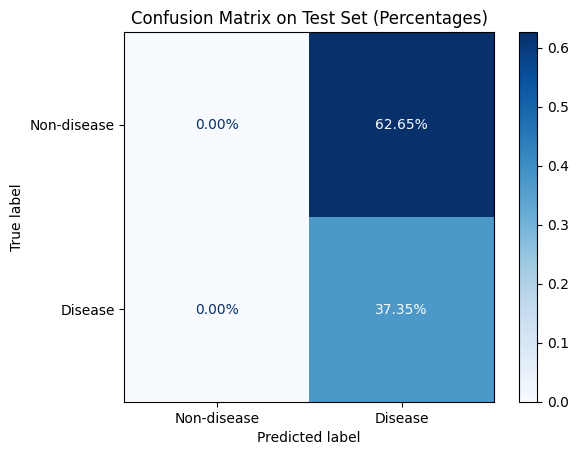

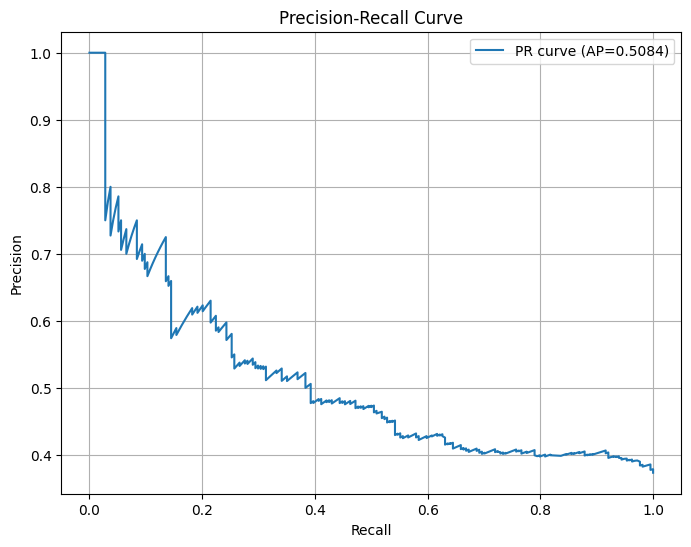

Best threshold by max F1: 0.5879
Precision: 0.4066, Recall: 0.9159, F1: 0.5632
Metrics at best threshold 0.5879:
Accuracy: 0.4695
Precision: 0.4066
Recall: 0.9159
F1 score: 0.5632


In [188]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)
input_dim = data.num_node_features

# Optionally define class weights, e.g. [weight_non_disease, weight_disease]
class_weights = [2, 3]

model, test_metrics = train_model(data, input_dim, device, class_weights=[3.0, 7.0])

# Threshold tuning and PR curve
best_threshold = threshold_tuning_and_pr_curve(test_metrics['probs'], test_metrics['true'])

# Apply best threshold
final_preds = (test_metrics['probs'] >= best_threshold).astype(int)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print(f"Metrics at best threshold {best_threshold:.4f}:")
print(f"Accuracy: {accuracy_score(test_metrics['true'], final_preds):.4f}")
print(f"Precision: {precision_score(test_metrics['true'], final_preds):.4f}")
print(f"Recall: {recall_score(test_metrics['true'], final_preds):.4f}")
print(f"F1 score: {f1_score(test_metrics['true'], final_preds):.4f}")

In [189]:
best_model, best_config, best_auc = hyperparameter_tuning(data, input_dim, device, class_weights=[3.0, 7.0])



Training with hidden_dim=32, dropout=0.3, lr=0.001
Epoch 001 | Loss: 0.6899 | Val AUC: 0.5641
Epoch 005 | Loss: 0.6786 | Val AUC: 0.5797
Epoch 010 | Loss: 0.6673 | Val AUC: 0.5864
Epoch 015 | Loss: 0.6631 | Val AUC: 0.5851
Epoch 020 | Loss: 0.6604 | Val AUC: 0.5827
Epoch 025 | Loss: 0.6546 | Val AUC: 0.5770
Epoch 030 | Loss: 0.6504 | Val AUC: 0.5669
Early stopping at epoch 30
Finished config hidden_dim=32, dropout=0.3, lr=0.001, best val AUC: 0.5864

Training with hidden_dim=32, dropout=0.3, lr=0.005
Epoch 001 | Loss: 0.6846 | Val AUC: 0.5601
Epoch 005 | Loss: 0.6611 | Val AUC: 0.5542
Epoch 010 | Loss: 0.6420 | Val AUC: 0.5395
Epoch 015 | Loss: 0.6285 | Val AUC: 0.5273
Epoch 020 | Loss: 0.6162 | Val AUC: 0.5235
Early stopping at epoch 20
Finished config hidden_dim=32, dropout=0.3, lr=0.005, best val AUC: 0.5601

Training with hidden_dim=32, dropout=0.3, lr=0.01
Epoch 001 | Loss: 0.6995 | Val AUC: 0.5298
Epoch 005 | Loss: 0.6545 | Val AUC: 0.5481
Epoch 010 | Loss: 0.6351 | Val AUC: 0.5

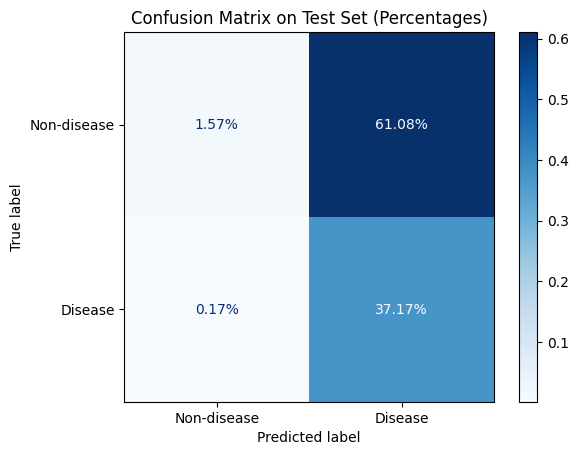

Test Accuracy: 0.3874
Test Precision: 0.3783
Test Recall: 0.9953
Test F1: 0.5483
Test AUC: 0.6378


In [190]:
test_idx = create_data_splits(data.num_nodes, data.y.cpu().numpy())[2]  # get test indices

test_metrics = evaluate(best_model, data, test_idx)

true = test_metrics['true']
preds = test_metrics['preds']  # or use final_preds if threshold tuned

cm = confusion_matrix(true, preds)
cm_norm = cm / cm.sum()

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=["Non-disease", "Disease"])
disp.plot(cmap=plt.cm.Blues, values_format=".2%")
plt.title("Confusion Matrix on Test Set (Percentages)")
plt.show()

print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Test Precision: {test_metrics['precision']:.4f}")
print(f"Test Recall: {test_metrics['recall']:.4f}")
print(f"Test F1: {test_metrics['f1']:.4f}")
print(f"Test AUC: {test_metrics['auc']:.4f}")

In [191]:
print(data.x.shape)  # to see number of nodes and features


torch.Size([2862, 753])


---------------------

In [192]:

# --- Models ---

class DiseaseGeneGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=self.dropout)
        x = self.conv2(x, edge_index)
        return x

class ResidualGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.conv4 = GCNConv(hidden_dim, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x1 = F.relu(self.bn1(self.conv1(x, edge_index)))
        x1 = F.dropout(x1, p=self.dropout, training=self.training)
        x2 = F.relu(self.bn2(self.conv2(x1, edge_index)))
        x2 = F.dropout(x2, p=self.dropout, training=self.training)
        x3 = F.relu(self.bn3(self.conv3(x2, edge_index)))
        x3 = F.dropout(x3, p=self.dropout, training=self.training)
        x = x3 + x1  # residual connection
        x = self.conv4(x, edge_index)
        return x

class DiseaseGeneGAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4, dropout=0.3):
        super().__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)
        return x

In [193]:

# --- Utilities ---

def compute_class_weights(labels):
    classes, counts = np.unique(labels, return_counts=True)
    total = labels.shape[0]
    weights = {cls: total/count for cls, count in zip(classes, counts)}
    return [weights[i] for i in range(len(classes))]

def create_kfold_splits(labels, n_splits=5, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    return list(skf.split(np.zeros(len(labels)), labels))

def train_epoch(model, data, optimizer, loss_fn, train_idx):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate(model, data, idx):
    model.eval()
    out = model(data)
    logits = out[idx]
    preds = logits.argmax(dim=1).cpu().numpy()
    probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
    true = data.y[idx].cpu().numpy()
    metrics = {
        'accuracy': accuracy_score(true, preds),
        'precision': precision_score(true, preds, zero_division=0),
        'recall': recall_score(true, preds, zero_division=0),
        'f1': f1_score(true, preds, zero_division=0),
        'auc': roc_auc_score(true, probs),
        'probs': probs,
        'preds': preds,
        'true': true
    }
    return metrics

def plot_confusion_matrix(true, preds, labels=["Non-disease", "Disease"], normalize=True):
    cm = confusion_matrix(true, preds)
    if normalize:
        cm = cm / cm.sum()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, values_format=".2%" if normalize else "d")
    plt.title("Confusion Matrix" + (" (Percentages)" if normalize else ""))
    plt.show()

def plot_roc_curve(true, probs):
    fpr, tpr, _ = roc_curve(true, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
def select_best_weights(fold_aucs, fold_weights):
    mean_auc = np.mean(fold_aucs)
    # Find fold index with auc closest to mean
    best_idx = np.argmin(np.abs(np.array(fold_aucs) - mean_auc))
    print(f"Mean val AUC: {mean_auc:.4f}, selected fold: {best_idx+1} with AUC: {fold_aucs[best_idx]:.4f}")
    return fold_weights[best_idx]


In [194]:

# --- Full cross-validation + hyperparameter tuning pipeline ---

def train_and_evaluate_cv(data, model_class, input_dim, device, class_weights=None,
                          hidden_dims=[64], dropouts=[0.5], lrs=[0.01], heads_list=[4],
                          epochs=200, patience=20, n_splits=5):

    labels = data.y.cpu().numpy()
    splits = create_kfold_splits(labels, n_splits)
    best_overall_auc = 0
    best_config = None
    best_model_state = None

    for hidden_dim in hidden_dims:
        for dropout in dropouts:
            for lr in lrs:
                for heads in heads_list:
                    print(f"Config: hidden_dim={hidden_dim}, dropout={dropout}, lr={lr}, heads={heads}")
                    fold_aucs = []
                    fold_models = []
                    for fold, (train_idx, val_idx) in enumerate(splits):
                        print(f" Fold {fold+1}/{n_splits}")
                        model_kwargs = {}
                        if model_class == DiseaseGeneGAT:
                            model_kwargs['heads'] = heads
                            model_kwargs['dropout'] = dropout
                        else:
                            model_kwargs['dropout'] = dropout

                        model = model_class(input_dim, hidden_dim, 2, **model_kwargs).to(device)
                        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

                        if class_weights is not None:
                            weight_tensor = torch.tensor(class_weights, device=device, dtype=torch.float)
                            loss_fn = nn.CrossEntropyLoss(weight=weight_tensor)
                        else:
                            loss_fn = nn.CrossEntropyLoss()

                        best_val_auc = 0
                        patience_counter = 0

                        for epoch in range(1, epochs+1):
                            loss = train_epoch(model, data, optimizer, loss_fn, train_idx)

                            if epoch % 5 == 0 or epoch == 1:
                                val_metrics = evaluate(model, data, val_idx)
                                print(f"  Epoch {epoch:03d} | Loss: {loss:.4f} | Val AUC: {val_metrics['auc']:.4f}")

                                if val_metrics['auc'] > best_val_auc:
                                    best_val_auc = val_metrics['auc']
                                    patience_counter = 0
                                    best_weights = model.state_dict()
                                else:
                                    patience_counter += 5

                                if patience_counter >= patience:
                                    print(f"  Early stopping at epoch {epoch}")
                                    break

                        fold_aucs.append(best_val_auc)
                        fold_models.append(best_weights)

                    mean_auc = np.mean(fold_aucs)
                    print(f" Mean val AUC over {n_splits} folds: {mean_auc:.4f}")

                    if mean_auc > best_overall_auc:
                        best_overall_auc = mean_auc
                        best_config = (hidden_dim, dropout, lr, heads)
                        best_model_state = fold_models[np.argmax(fold_aucs)]

    print(f"\nBest config: hidden_dim={best_config[0]}, dropout={best_config[1]}, lr={best_config[2]}, "
          f"heads={best_config[3] if model_class==DiseaseGeneGAT else 'N/A'}, mean val AUC={best_overall_auc:.4f}")

    # Load best model weights and evaluate on all data
    best_model_kwargs = {}
    if model_class == DiseaseGeneGAT:
        best_model_kwargs['heads'] = best_config[3]
        best_model_kwargs['dropout'] = best_config[1]
    else:
        best_model_kwargs['dropout'] = best_config[1]

    best_model = model_class(input_dim, best_config[0], 2, **best_model_kwargs).to(device)
    best_model.load_state_dict(best_model_state)
    best_model.eval()

    test_metrics = evaluate(best_model, data, list(range(data.num_nodes)))

    print(f"\nTest metrics on all data: Acc={test_metrics['accuracy']:.4f}, Prec={test_metrics['precision']:.4f}, "
          f"Recall={test_metrics['recall']:.4f}, F1={test_metrics['f1']:.4f}, AUC={test_metrics['auc']:.4f}")

    plot_confusion_matrix(test_metrics['true'], test_metrics['preds'], normalize=True)
    plot_roc_curve(test_metrics['true'], test_metrics['probs'])

    os.makedirs("output/models", exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name = model_class.__name__
    model_filename = f"output/models/{model_name}_best_model_{timestamp}.pth"
    torch.save(best_model.state_dict(), model_filename)
    print(f"Best model saved to '{model_filename}'")

    return best_model, best_config, test_metrics

In [195]:
class_weights = compute_class_weights(data.y.cpu().numpy())
class_weights

[np.float64(1.5970982142857142), np.float64(2.674766355140187)]


Training DiseaseGeneGCN ...
Config: hidden_dim=64, dropout=0.3, lr=0.01, heads=4
 Fold 1/3
  Epoch 001 | Loss: 0.7004 | Val AUC: 0.5671
  Epoch 005 | Loss: 0.6622 | Val AUC: 0.5366
  Epoch 010 | Loss: 0.6332 | Val AUC: 0.5537
  Early stopping at epoch 10
 Fold 2/3
  Epoch 001 | Loss: 0.6908 | Val AUC: 0.4853
  Epoch 005 | Loss: 0.6591 | Val AUC: 0.5789
  Epoch 010 | Loss: 0.6319 | Val AUC: 0.5917
  Epoch 015 | Loss: 0.6109 | Val AUC: 0.5918
  Epoch 020 | Loss: 0.5931 | Val AUC: 0.5929
  Epoch 025 | Loss: 0.5740 | Val AUC: 0.5879
  Epoch 030 | Loss: 0.5652 | Val AUC: 0.5910
  Early stopping at epoch 30
 Fold 3/3
  Epoch 001 | Loss: 0.6926 | Val AUC: 0.5595
  Epoch 005 | Loss: 0.6530 | Val AUC: 0.5602
  Epoch 010 | Loss: 0.6187 | Val AUC: 0.5661
  Epoch 015 | Loss: 0.5913 | Val AUC: 0.5742
  Epoch 020 | Loss: 0.5704 | Val AUC: 0.5705
  Epoch 025 | Loss: 0.5577 | Val AUC: 0.5704
  Early stopping at epoch 25
 Mean val AUC over 3 folds: 0.5781

Best config: hidden_dim=64, dropout=0.3, lr=0

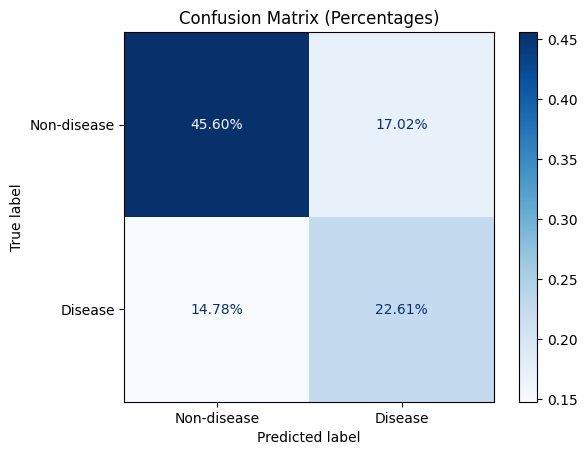

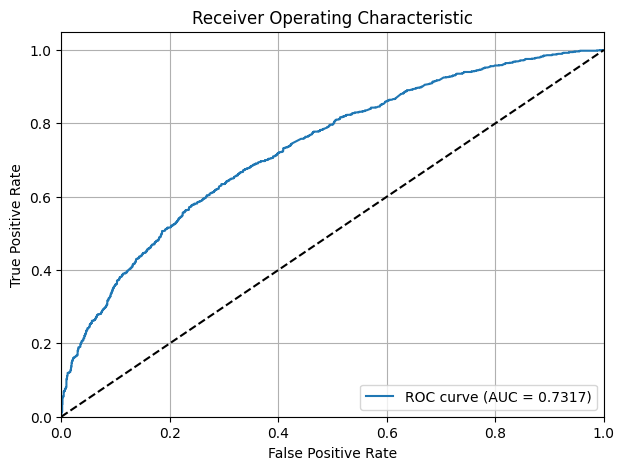

Best model saved to 'output/models/DiseaseGeneGCN_best_model_20250706_201128.pth'

Training ResidualGCN ...
Config: hidden_dim=64, dropout=0.3, lr=0.01, heads=4
 Fold 1/3
  Epoch 001 | Loss: 1.3500 | Val AUC: 0.4488
  Epoch 005 | Loss: 0.7200 | Val AUC: 0.5786
  Epoch 010 | Loss: 0.6317 | Val AUC: 0.5093
  Epoch 015 | Loss: 0.5822 | Val AUC: 0.5321
  Early stopping at epoch 15
 Fold 2/3
  Epoch 001 | Loss: 0.9780 | Val AUC: 0.4540
  Epoch 005 | Loss: 0.8554 | Val AUC: 0.5568
  Epoch 010 | Loss: 0.7522 | Val AUC: 0.4878
  Epoch 015 | Loss: 0.6538 | Val AUC: 0.5606
  Epoch 020 | Loss: 0.6261 | Val AUC: 0.5303
  Epoch 025 | Loss: 0.5863 | Val AUC: 0.5598
  Early stopping at epoch 25
 Fold 3/3
  Epoch 001 | Loss: 1.1159 | Val AUC: 0.5573
  Epoch 005 | Loss: 0.7154 | Val AUC: 0.5009
  Epoch 010 | Loss: 0.6242 | Val AUC: 0.5780
  Epoch 015 | Loss: 0.5961 | Val AUC: 0.5297
  Epoch 020 | Loss: 0.5791 | Val AUC: 0.5488
  Early stopping at epoch 20
 Mean val AUC over 3 folds: 0.5724

Best config

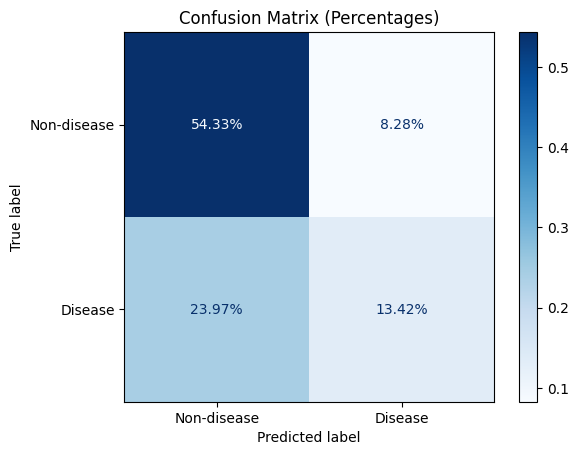

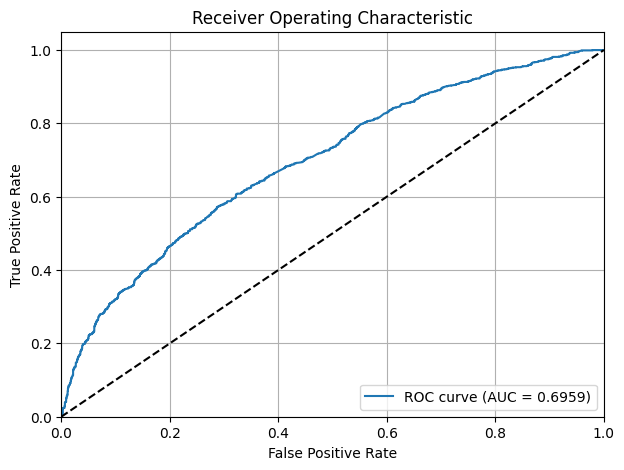

Best model saved to 'output/models/ResidualGCN_best_model_20250706_201131.pth'

Training DiseaseGeneGAT ...
Config: hidden_dim=64, dropout=0.3, lr=0.01, heads=4
 Fold 1/3
  Epoch 001 | Loss: 0.7007 | Val AUC: 0.5277
  Epoch 005 | Loss: 0.6592 | Val AUC: 0.5567
  Epoch 010 | Loss: 0.6540 | Val AUC: 0.5643
  Epoch 015 | Loss: 0.6489 | Val AUC: 0.5722
  Epoch 020 | Loss: 0.6403 | Val AUC: 0.5717
  Epoch 025 | Loss: 0.6315 | Val AUC: 0.5705
  Early stopping at epoch 25
 Fold 2/3
  Epoch 001 | Loss: 0.6998 | Val AUC: 0.4789
  Epoch 005 | Loss: 0.7433 | Val AUC: 0.6082
  Epoch 010 | Loss: 0.6853 | Val AUC: 0.5812
  Epoch 015 | Loss: 0.6708 | Val AUC: 0.6033
  Early stopping at epoch 15
 Fold 3/3
  Epoch 001 | Loss: 0.6940 | Val AUC: 0.5192
  Epoch 005 | Loss: 0.6672 | Val AUC: 0.5513
  Epoch 010 | Loss: 0.6529 | Val AUC: 0.5638
  Epoch 015 | Loss: 0.6454 | Val AUC: 0.5725
  Epoch 020 | Loss: 0.6324 | Val AUC: 0.5696
  Epoch 025 | Loss: 0.6217 | Val AUC: 0.5765
  Epoch 030 | Loss: 0.6052 | Va

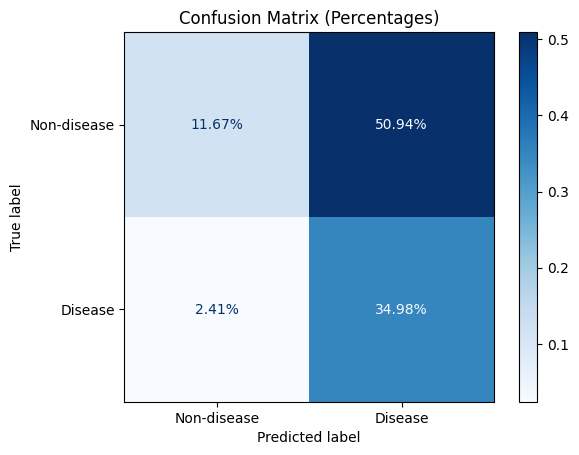

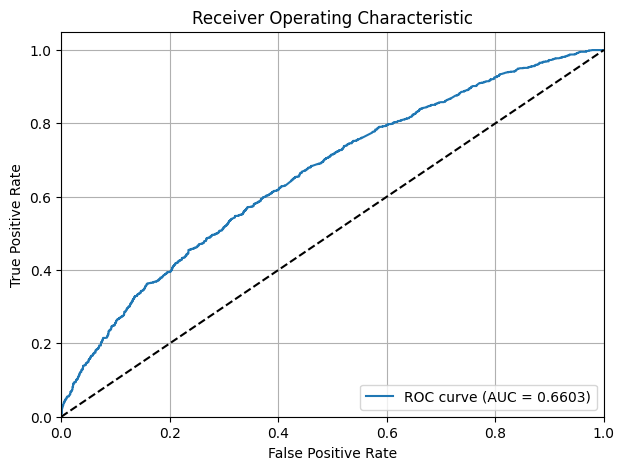

Best model saved to 'output/models/DiseaseGeneGAT_best_model_20250706_201136.pth'


In [196]:
from sklearn.metrics import auc

models_to_run = [DiseaseGeneGCN, ResidualGCN, DiseaseGeneGAT]

for model_cls in models_to_run:
    print(f"\nTraining {model_cls.__name__} ...")
    best_model, best_config, test_metrics = train_and_evaluate_cv(
        data=data,
        model_class=model_cls,
        input_dim=data.num_node_features,
        device=device,
        class_weights=class_weights,
        hidden_dims=[64],       # adjust as needed
        dropouts=[0.3],
        lrs=[0.01],
        heads_list=[4],         # heads ignored except for GAT
        epochs=50,
        patience=10,
        n_splits=3
    )

In [197]:

class ResidualAttentionGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4, dropout=0.5):
        super().__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=dropout)
        self.bn1 = nn.BatchNorm1d(hidden_dim * heads)
        
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads, dropout=dropout)
        self.bn2 = nn.BatchNorm1d(hidden_dim * heads)
        
        self.gat3 = GATConv(hidden_dim * heads, hidden_dim, heads=heads, dropout=dropout)
        self.bn3 = nn.BatchNorm1d(hidden_dim * heads)
        
        self.lin = nn.Linear(hidden_dim * heads, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x1 = F.elu(self.bn1(self.gat1(x, edge_index)))
        x1 = F.dropout(x1, p=self.dropout, training=self.training)
        
        x2 = F.elu(self.bn2(self.gat2(x1, edge_index)))
        x2 = F.dropout(x2, p=self.dropout, training=self.training)
        
        x3 = F.elu(self.bn3(self.gat3(x2, edge_index)))
        x3 = F.dropout(x3, p=self.dropout, training=self.training)
        
        x = x3 + x1  # residual connection
        
        x = self.lin(x)
        return x


from torch_geometric.nn import SAGEConv

class DiseaseGeneGraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return x


Training and evaluating DiseaseGeneGraphSAGE ...
Config: hidden_dim=64, dropout=0.3, lr=0.01, heads=4
 Fold 1/3
  Epoch 001 | Loss: 0.7065 | Val AUC: 0.5111
  Epoch 005 | Loss: 0.6538 | Val AUC: 0.5789
  Epoch 010 | Loss: 0.5690 | Val AUC: 0.5696
  Epoch 015 | Loss: 0.4858 | Val AUC: 0.5456
  Epoch 020 | Loss: 0.4049 | Val AUC: 0.5206
  Early stopping at epoch 20
 Fold 2/3
  Epoch 001 | Loss: 0.6995 | Val AUC: 0.4765
  Epoch 005 | Loss: 0.6732 | Val AUC: 0.6109
  Epoch 010 | Loss: 0.5912 | Val AUC: 0.6231
  Epoch 015 | Loss: 0.5036 | Val AUC: 0.5713
  Epoch 020 | Loss: 0.4096 | Val AUC: 0.5138
  Epoch 025 | Loss: 0.3551 | Val AUC: 0.5110
  Early stopping at epoch 25
 Fold 3/3
  Epoch 001 | Loss: 0.6974 | Val AUC: 0.5327
  Epoch 005 | Loss: 0.6596 | Val AUC: 0.5825
  Epoch 010 | Loss: 0.5710 | Val AUC: 0.5864
  Epoch 015 | Loss: 0.4911 | Val AUC: 0.5458
  Epoch 020 | Loss: 0.4120 | Val AUC: 0.5173
  Epoch 025 | Loss: 0.3485 | Val AUC: 0.5167
  Early stopping at epoch 25
 Mean val AUC o

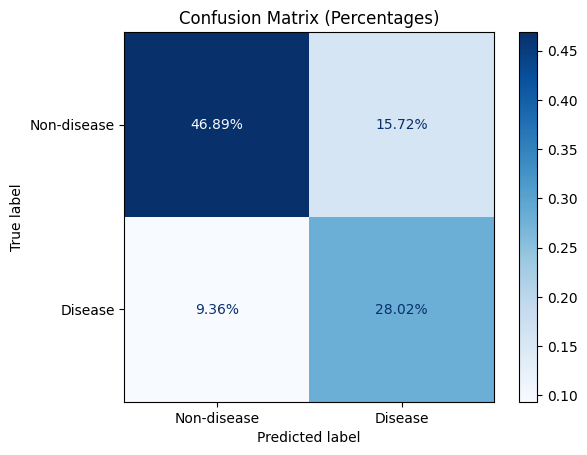

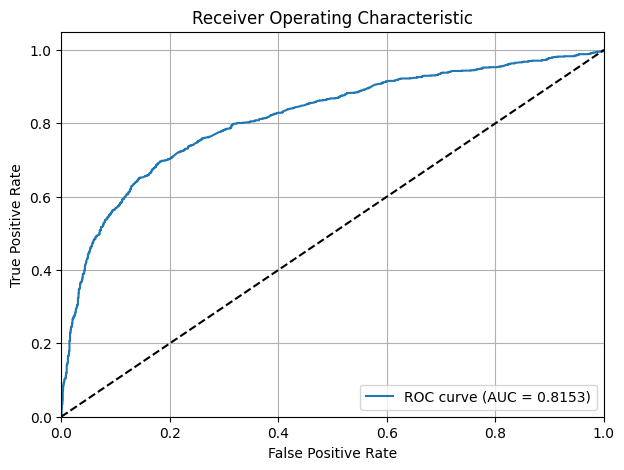

Best model saved to 'output/models/DiseaseGeneGraphSAGE_best_model_20250706_201139.pth'
Finished DiseaseGeneGraphSAGE with config: (64, 0.3, 0.01, 4)
Test metrics: Acc=0.7491, Prec=0.6406, Recall=0.7495, F1=0.6908, AUC=0.8153

Training and evaluating ResidualAttentionGCN ...
Config: hidden_dim=64, dropout=0.3, lr=0.01, heads=4
 Fold 1/3
  Epoch 001 | Loss: 0.8393 | Val AUC: 0.5499
  Epoch 005 | Loss: 0.6551 | Val AUC: 0.5396
  Epoch 010 | Loss: 0.6434 | Val AUC: 0.5656
  Epoch 015 | Loss: 0.5997 | Val AUC: 0.5862
  Epoch 020 | Loss: 0.5837 | Val AUC: 0.5623
  Epoch 025 | Loss: 0.5520 | Val AUC: 0.5656
  Epoch 030 | Loss: 0.5290 | Val AUC: 0.5551
  Early stopping at epoch 30
 Fold 2/3
  Epoch 001 | Loss: 0.8307 | Val AUC: 0.5285
  Epoch 005 | Loss: 0.6904 | Val AUC: 0.4979
  Epoch 010 | Loss: 0.6543 | Val AUC: 0.5581
  Epoch 015 | Loss: 0.6134 | Val AUC: 0.6012
  Epoch 020 | Loss: 0.5884 | Val AUC: 0.5654
  Epoch 025 | Loss: 0.5528 | Val AUC: 0.5677
  Epoch 030 | Loss: 0.5370 | Val AUC:

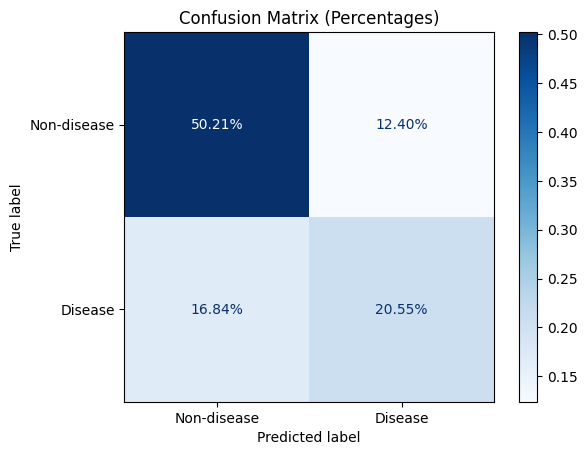

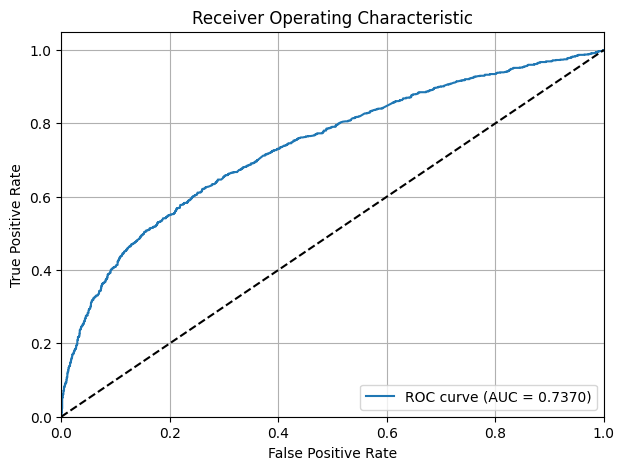

Best model saved to 'output/models/ResidualAttentionGCN_best_model_20250706_201156.pth'
Finished ResidualAttentionGCN with config: (64, 0.3, 0.01, 4)
Test metrics: Acc=0.7075, Prec=0.6235, Recall=0.5495, F1=0.5842, AUC=0.7370


In [198]:
models_to_run = [DiseaseGeneGraphSAGE, ResidualAttentionGCN]

for model_cls in models_to_run:
    print(f"\nTraining and evaluating {model_cls.__name__} ...")
    best_model, best_config, test_metrics = train_and_evaluate_cv(
        data=data,
        model_class=model_cls,
        input_dim=data.num_node_features,
        device=device,
        class_weights=class_weights,
        hidden_dims=[64],
        dropouts=[0.3],
        lrs=[0.01],
        heads_list=[4],  # used only by ResidualAttentionGCN
        epochs=100,
        patience=15,
        n_splits=3
    )
    print(f"Finished {model_cls.__name__} with config: {best_config}")
    print(f"Test metrics: Acc={test_metrics['accuracy']:.4f}, Prec={test_metrics['precision']:.4f}, "
          f"Recall={test_metrics['recall']:.4f}, F1={test_metrics['f1']:.4f}, AUC={test_metrics['auc']:.4f}")


------------------

### Extra EDA

In [199]:
disease_genes_in_df = df_simplified[df_simplified['Label'] == 1].index.tolist()  # or df_simplified['Gene']

# Build subgraph including neighbors
nodes = set(disease_genes_in_df)
for gene in disease_genes_in_df:
    if gene in G:
        nodes.update(G.neighbors(gene))

disease_subgraph = G.subgraph(nodes).copy()

# Compute network metrics
size = disease_subgraph.number_of_nodes()
density = nx.density(disease_subgraph)
try:
    diameter = nx.diameter(disease_subgraph.to_undirected())
except nx.NetworkXError:
    diameter = float('nan')
avg_degree = sum(dict(disease_subgraph.degree()).values()) / size if size > 0 else float('nan')

print(f"Disease subgraph size: {size}")
print(f"Disease subgraph density: {density:.4f}")
print(f"Disease subgraph diameter: {diameter}")
print(f"Disease subgraph average degree: {avg_degree:.2f}")

Disease subgraph size: 2070
Disease subgraph density: 0.0015
Disease subgraph diameter: nan
Disease subgraph average degree: 6.39


In [200]:
# Aggregate disease names per gene (multiple possible)
disease_types = disease_df.groupby('GeneName')['DiseaseName'].apply(lambda x: '; '.join(set(x))).reset_index()

# Merge with df_simplified
df_simplified = df_simplified.reset_index()  # if gene names are index
df_simplified = pd.merge(df_simplified, disease_types, left_on='Gene', right_on='GeneName', how='left')


In [214]:
df_simplified.head()

,Gene,DegreeCentrality,Betweenness,Closeness,Community_0.0,Community_1.0,Community_2.0,Community_3.0,Community_4.0,Community_5.0,...,TFRole_Unknown,TFRole_nan,TFRole_Activator.1,TFRole_Dual.1,TFRole_Repressor.1,TFRole_Unknown.1,TFRole_nan.1,Label,GeneName,DiseaseName
0,AATF,0.001748,0.000000,0.000000,False,True,False,False,False,False,...,False,False,False,True,False,False,False,0,NaN,NaN
1,BAX,0.009088,0.000000,0.056523,False,True,False,False,False,False,...,False,True,False,False,False,True,False,1,BAX,ICD10:C8; Disease; ICD10:C80; ICD10:D48; ICD10...
2,CDKN1A,0.040196,0.000000,0.081985,False,True,False,False,False,False,...,False,True,False,False,False,True,False,1,CDKN1A,Urinary system disease; ICD10:D4; ICD10:N3; Di...
3,KLK3,0.008738,0.000000,0.056989,False,False,False,False,False,False,...,False,True,False,False,False,True,False,0,NaN,NaN
4,MYC,0.060818,0.017672,0.071214,False,True,False,False,False,False,...,False,False,False,True,False,False,False,1,MYC,ICD10:C8; Disease; ICD10:C80; ICD10:D48; ICD10...


In [216]:
# 1. Drop missing values
disease_series = df_simplified['DiseaseName'].dropna()

# 2. Split the semicolon-separated strings into lists, then explode into separate rows
disease_terms = disease_series.str.split(';').explode().str.strip()

# 3. Count occurrences of each individual disease term
term_counts = disease_terms.value_counts()

print(term_counts.head(20))  # Show top 20 most frequent disease terms

DiseaseName
Disease                              1069
ICD10:root                            994
Disease of anatomical entity          792
Genetic disease                       468
Monogenic disease                     363
ICD10:D                               327
Nervous system disease                325
Autosomal genetic disease             299
ICD10:E                               267
ICD10:C                               257
ICD10:D4                              257
Disease of cellular proliferation     257
ICD10:D48                             257
Cancer                                256
ICD10:C80                             256
ICD10:C8                              256
Musculoskeletal system disease        216
ICD10:G                               201
Autosomal dominant disease            182
ICD10:E8                              176
Name: count, dtype: int64


In [222]:
term_counts

DiseaseName
Disease                                            1069
ICD10:root                                          994
Disease of anatomical entity                        792
Genetic disease                                     468
Monogenic disease                                   363
                                                   ... 
Hereditary fibrinogen A alpha-chain Amyloidosis       1
Hypophosphatemia                                      1
Phosphorus metabolism disease                         1
ICD10:E21                                             1
ICD10:E215                                            1
Name: count, Length: 1609, dtype: int64

In [223]:
df_simplified.head()

,Gene,DegreeCentrality,Betweenness,Closeness,Community_0.0,Community_1.0,Community_2.0,Community_3.0,Community_4.0,Community_5.0,...,TFRole_Unknown,TFRole_nan,TFRole_Activator.1,TFRole_Dual.1,TFRole_Repressor.1,TFRole_Unknown.1,TFRole_nan.1,Label,GeneName,DiseaseName
0,AATF,0.001748,0.000000,0.000000,False,True,False,False,False,False,...,False,False,False,True,False,False,False,0,NaN,NaN
1,BAX,0.009088,0.000000,0.056523,False,True,False,False,False,False,...,False,True,False,False,False,True,False,1,BAX,ICD10:C8; Disease; ICD10:C80; ICD10:D48; ICD10...
2,CDKN1A,0.040196,0.000000,0.081985,False,True,False,False,False,False,...,False,True,False,False,False,True,False,1,CDKN1A,Urinary system disease; ICD10:D4; ICD10:N3; Di...
3,KLK3,0.008738,0.000000,0.056989,False,False,False,False,False,False,...,False,True,False,False,False,True,False,0,NaN,NaN
4,MYC,0.060818,0.017672,0.071214,False,True,False,False,False,False,...,False,False,False,True,False,False,False,1,MYC,ICD10:C8; Disease; ICD10:C80; ICD10:D48; ICD10...


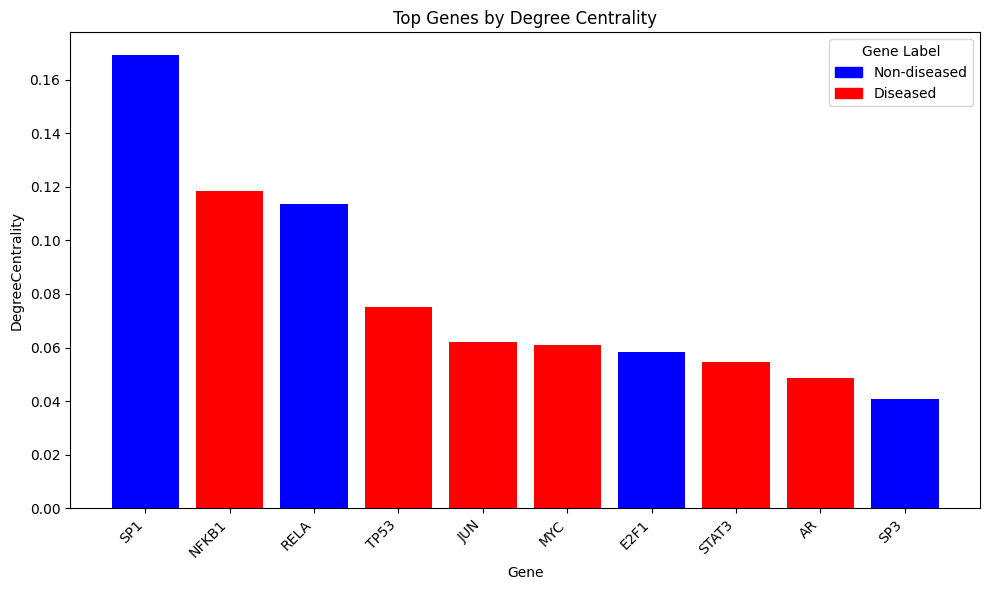

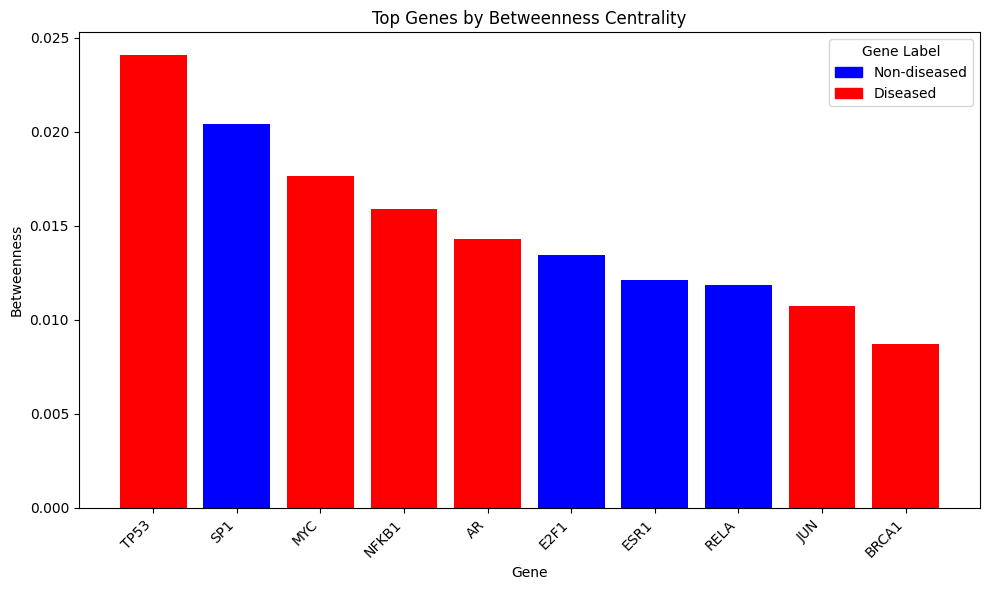

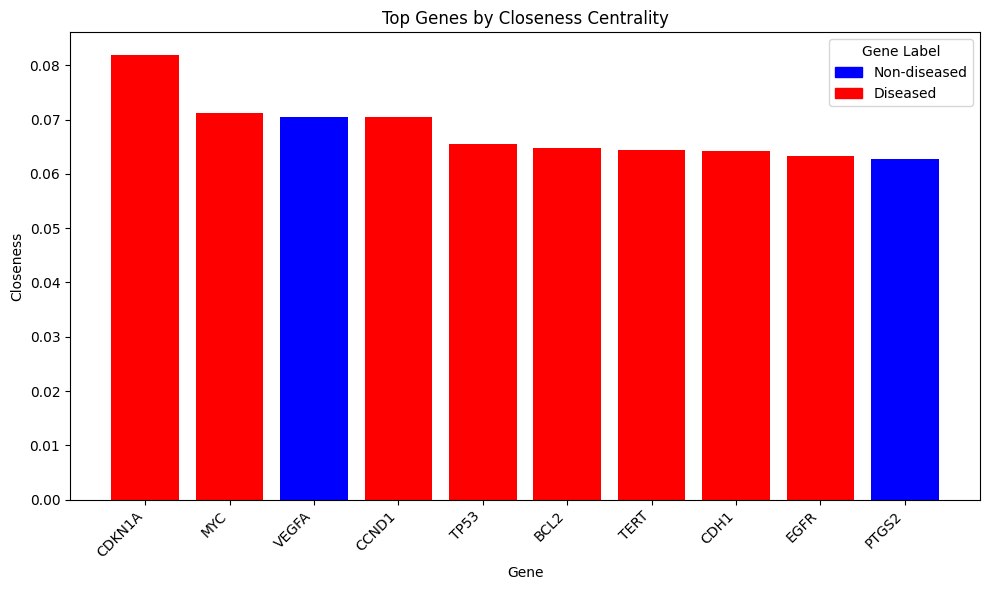

In [227]:
import matplotlib.patches as mpatches

# Number of top genes to show
top_n = 10

# Extract top genes for each centrality
top_degree = df_simplified.nlargest(top_n, 'DegreeCentrality')
top_betweenness = df_simplified.nlargest(top_n, 'Betweenness')
top_closeness = df_simplified.nlargest(top_n, 'Closeness')

# Define a color map for labels (adjust colors as you want)
label_colors = {0: 'blue', 1: 'red'}

def plot_top_genes(df_top, centrality_col, title):
    plt.figure(figsize=(10, 6))
    colors = df_top['Label'].map(label_colors)
    bars = plt.bar(df_top['Gene'], df_top[centrality_col], color=colors)
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.xlabel('Gene')
    plt.ylabel(centrality_col)

    # Create legend patches
    blue_patch = mpatches.Patch(color='blue', label='Non-diseased')
    red_patch = mpatches.Patch(color='red', label='Diseased')
    plt.legend(handles=[blue_patch, red_patch], title='Gene Label')

    plt.tight_layout()
    plt.show()

plot_top_genes(top_degree, 'DegreeCentrality', 'Top Genes by Degree Centrality')
plot_top_genes(top_betweenness, 'Betweenness', 'Top Genes by Betweenness Centrality')
plot_top_genes(top_closeness, 'Closeness', 'Top Genes by Closeness Centrality')

In [230]:
from scipy.stats import mannwhitneyu
# Function to summarize stats and run Mann-Whitney U test
def compare_labels(df, column):
    group0 = df[df['Label'] == 0][column].dropna()
    group1 = df[df['Label'] == 1][column].dropna()
    
    print(f"--- {column} ---")
    print(f"Non-diseased (n={len(group0)}): median={group0.median():.5f}, mean={group0.mean():.5f}, std={group0.std():.5f}")
    print(f"Diseased (n={len(group1)}): median={group1.median():.5f}, mean={group1.mean():.5f}, std={group1.std():.5f}")
    
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    print(f"Mann-Whitney U test p-value: {p:.4e}")
    print()

# Columns to compare
columns = ['DegreeCentrality', 'Betweenness', 'Closeness']

for col in columns:
    compare_labels(df_simplified, col)

--- DegreeCentrality ---
Non-diseased (n=1792): median=0.00070, mean=0.00171, std=0.00583
Diseased (n=1070): median=0.00105, mean=0.00264, std=0.00671
Mann-Whitney U test p-value: 3.7875e-13

--- Betweenness ---
Non-diseased (n=1792): median=0.00000, mean=0.00009, std=0.00079
Diseased (n=1070): median=0.00000, mean=0.00022, std=0.00132
Mann-Whitney U test p-value: 3.9577e-05

--- Closeness ---
Non-diseased (n=1792): median=0.03804, mean=0.03173, std=0.01786
Diseased (n=1070): median=0.03933, mean=0.03479, std=0.01696
Mann-Whitney U test p-value: 2.4902e-06



In [243]:

metrics_per_community = []

for community_id in set(community_dict.values()):
    # Get nodes in this community
    nodes_in_comm = [node for node, comm in community_dict.items() if comm == community_id]
    subgraph = G.subgraph(nodes_in_comm)
    
    # Calculate average degree (undirected degree since clustering requires undirected)
    degrees = dict(subgraph.degree())
    avg_degree = sum(degrees.values()) / len(degrees) if len(degrees) > 0 else 0
    
    # Average clustering coefficient on undirected version of subgraph
    avg_clustering = nx.average_clustering(subgraph.to_undirected()) if len(subgraph) > 0 else 0
    
    # Centrality measures
    deg_cent = nx.degree_centrality(subgraph) if len(subgraph) > 0 else {}
    avg_deg_cent = sum(deg_cent.values()) / len(deg_cent) if deg_cent else 0
    
    bet_cent = nx.betweenness_centrality(subgraph) if len(subgraph) > 0 else {}
    avg_bet_cent = sum(bet_cent.values()) / len(bet_cent) if bet_cent else 0
    
    close_cent = nx.closeness_centrality(subgraph) if len(subgraph) > 0 else {}
    avg_close_cent = sum(close_cent.values()) / len(close_cent) if close_cent else 0
    
    metrics_per_community.append({
        'Community': community_id,
        'Size': len(nodes_in_comm),
        'AvgDegree': avg_degree,
        'AvgClustering': avg_clustering,
        'AvgDegreeCentrality': avg_deg_cent,
        'AvgBetweennessCentrality': avg_bet_cent,
        'AvgClosenessCentrality': avg_close_cent
    })

df_metrics = pd.DataFrame(metrics_per_community)
print(df_metrics.sort_values('Community'))

    Community  Size  AvgDegree  AvgClustering  AvgDegreeCentrality  \
0           0   344   3.191860       0.156755             0.009306   
1           1   292   3.616438       0.152873             0.012428   
2           2   291   4.646048       0.469620             0.016021   
3           3   230   3.191304       0.055639             0.013936   
4           4   192   3.135417       0.099973             0.016416   
5           5   179   2.782123       0.055134             0.015630   
6           6   172   2.627907       0.068381             0.015368   
7           7   169   2.686391       0.083105             0.015990   
8           8   159   2.981132       0.038203             0.018868   
9           9   143   3.020979       0.066521             0.021275   
10         10   140   3.142857       0.052794             0.022610   
11         11   128   2.843750       0.041134             0.022392   
12         12   100   2.620000       0.076371             0.026465   
13         13    85 

In [244]:
df_metrics.sort_values('Community')

,Community,Size,AvgDegree,AvgClustering,AvgDegreeCentrality,AvgBetweennessCentrality,AvgClosenessCentrality
0,0,344,3.191860,0.156755,0.009306,0.000017,0.005435
1,1,292,3.616438,0.152873,0.012428,0.001053,0.048243
2,2,291,4.646048,0.469620,0.016021,0.000425,0.024539
3,3,230,3.191304,0.055639,0.013936,0.000729,0.014951
4,4,192,3.135417,0.099973,0.016416,0.000688,0.023706
5,5,179,2.782123,0.055134,0.015630,0.000160,0.013282
6,6,172,2.627907,0.068381,0.015368,0.000741,0.034033
7,7,169,2.686391,0.083105,0.015990,0.000222,0.015772
8,8,159,2.981132,0.038203,0.018868,0.000096,0.013437
9,9,143,3.020979,0.066521,0.021275,0.001167,0.031822


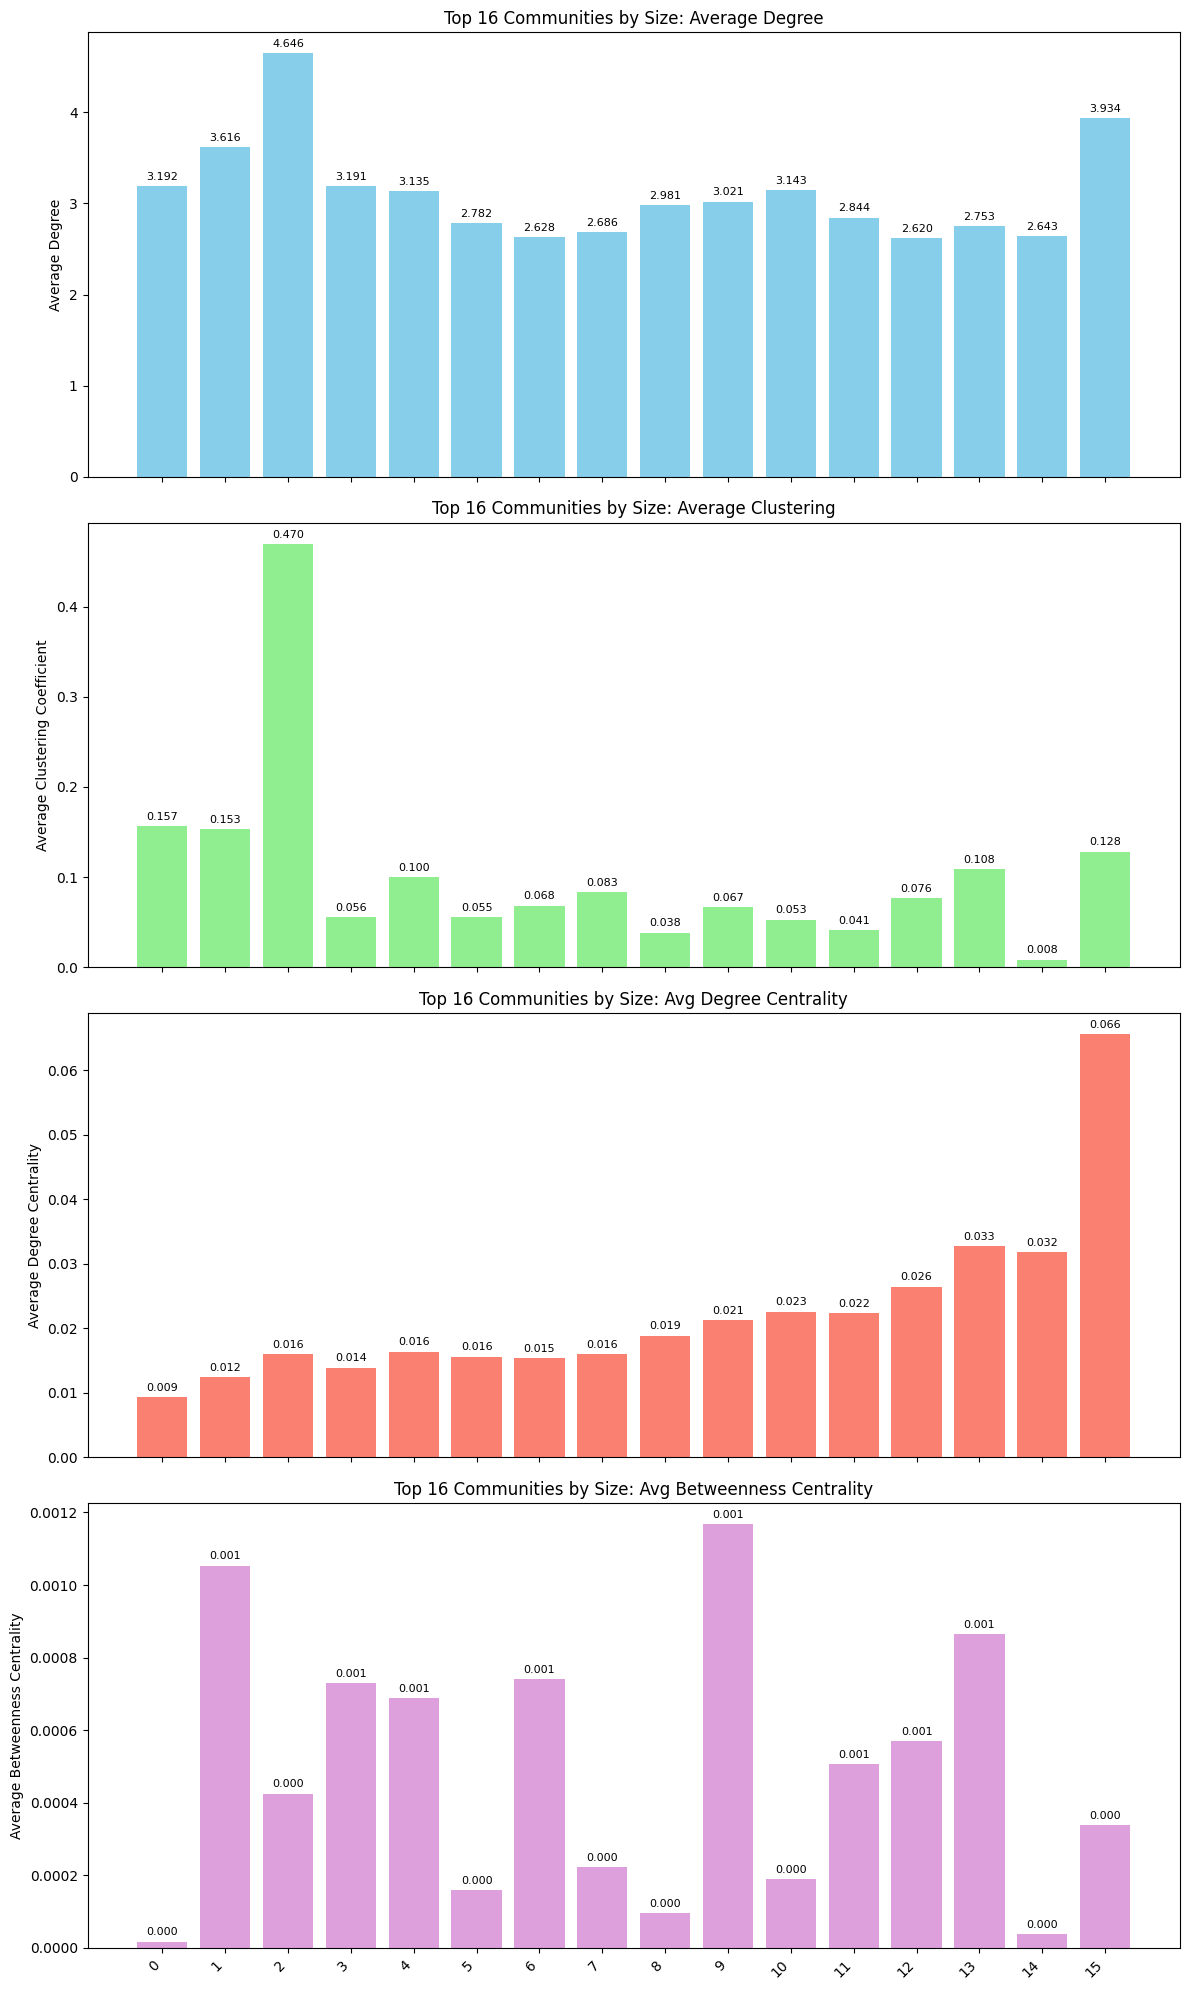

In [249]:
import matplotlib.pyplot as plt

def add_values_and_labels(ax, values, labels):
    max_val = max(values)
    for i, (v, label) in enumerate(zip(values, labels)):
        # Add value on top of bar
        ax.text(i, v + max_val*0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=8)
        # Add community label above the value (optional, if you want)
        #ax.text(i, v + max_val*0.05, f"Comm {label}", ha='center', va='bottom', fontsize=7, color='gray')

# Sort by community size descending and pick top 16
top16 = df_metrics.sort_values('Size', ascending=False).head(16)

fig, axs = plt.subplots(4, 1, figsize=(12, 20), sharex=True)

indices = range(len(top16))
comm_labels = top16['Community'].astype(str)

# Average Degree
axs[0].bar(indices, top16['AvgDegree'], color='skyblue')
axs[0].set_ylabel('Average Degree')
axs[0].set_title('Top 16 Communities by Size: Average Degree')
add_values_and_labels(axs[0], top16['AvgDegree'], comm_labels)

# Average Clustering Coefficient
axs[1].bar(indices, top16['AvgClustering'], color='lightgreen')
axs[1].set_ylabel('Average Clustering Coefficient')
axs[1].set_title('Top 16 Communities by Size: Average Clustering')
add_values_and_labels(axs[1], top16['AvgClustering'], comm_labels)

# Average Degree Centrality
axs[2].bar(indices, top16['AvgDegreeCentrality'], color='salmon')
axs[2].set_ylabel('Average Degree Centrality')
axs[2].set_title('Top 16 Communities by Size: Avg Degree Centrality')
add_values_and_labels(axs[2], top16['AvgDegreeCentrality'], comm_labels)

# Average Betweenness Centrality
axs[3].bar(indices, top16['AvgBetweennessCentrality'], color='plum')
axs[3].set_ylabel('Average Betweenness Centrality')
axs[3].set_title('Top 16 Communities by Size: Avg Betweenness Centrality')
add_values_and_labels(axs[3], top16['AvgBetweennessCentrality'], comm_labels)

axs[3].set_xticks(indices)
axs[3].set_xticklabels(comm_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()
